# Прогнозирование оттока клиентов оператора связи «ТелеДом»

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов со значением метрики качества ROC-AUC не меньше 0.85.

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

Данные состоят из нескольких файлов, полученных из разных источников.

**Файл `contract_new.csv` — информация о договоре:**
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

**Файл `personal_new.csv` — персональные данные клиента:**
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

**Файл `internet_new.csv` — информация об интернет-услугах:**
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

**Файл `phone_new.csv` — информация об услугах телефонии:**
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

## Подготовка

Установим и импортируем необходимые библиотеки, объявим вспомогательные функции, зафиксируем рандомстейт.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import phik
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (
    GridSearchCV, 
    StratifiedKFold, 
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
    StandardScaler
)
from sklearn.svm import SVC

In [6]:
class ColumnSelector():
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.columns is not None:
            return X[self.columns]
        else:
            return X

    def set_params(self, columns):
        self.columns = columns
        return self


def display_df_basic_info(df, count=5):
    display(df.head(count))
    df.info()

In [7]:
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', None)

In [8]:
RANDOM_STATE = 42

## Загрузка и предобработка данных

### Информация о договоре

Считаем CSV-файл с информацией о договоре и сохраним его в датафрейм `contract_df`.

In [12]:
csv_local_path = 'datasets/contract_new.csv'
csv_remote_path = 'https://example.com/datasets/contract_new.csv'
if os.path.exists(csv_local_path):
    contract_df = pd.read_csv(csv_local_path, parse_dates=['BeginDate'], index_col=['customerID'])
else:
    contract_df = pd.read_csv(csv_remote_path, parse_dates=['BeginDate'], index_col=['customerID'])

display_df_basic_info(contract_df)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


Признак `EndDate` имеет строковый тип, а не тип с датой/временем. Проблема в значениях `No` для действующих договоров — получается, из признака `EndDate` мы можем **выделить таргет (разорван ли договор)**.

In [14]:
contract_df['Reject'] = np.where(contract_df['EndDate'] == 'No', 'No', 'Yes')

Кроме того, из признаков `BeginDate` и `EndDate` можно вычислить длительность разорванного договора (или текущую длительность для действующего договора на дату выгрузки данных `2020-02-01`).

In [16]:
contract_df['EndDate'] = (
    contract_df['EndDate']
    .where(contract_df['EndDate'] != 'No', '2020-02-01')
    .astype('datetime64[ns]')
)
contract_df['DurationDays'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days

Необходимую информацию из признаков `BeginDate` и `EndDate` мы вытащили, теперь их можно удалить.

In [18]:
contract_df = contract_df.drop(columns=['BeginDate', 'EndDate'])

Признак `TotalCharges` имеет строковый, а не числовой тип. Проблема в «пробельных» значениях, посмотрим внимательнее.

In [20]:
contract_df[contract_df['TotalCharges'] == ' '].head(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Reject,DurationDays
customerID,,,,,,,
4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,,No,0
3115-CZMZD,Two year,No,Mailed check,20.25,,No,0
5709-LVOEQ,Two year,No,Mailed check,80.85,,No,0
4367-NUYAO,Two year,No,Mailed check,25.75,,No,0
1371-DWPAZ,Two year,No,Credit card (automatic),56.05,,No,0
7644-OMVMY,Two year,No,Mailed check,19.85,,No,0
3213-VVOLG,Two year,No,Mailed check,25.35,,No,0
2520-SGTTA,Two year,No,Mailed check,20.00,,No,0
2923-ARZLG,One year,Yes,Mailed check,19.70,,No,0


Мы видим, что «пробельные» значения признака `TotalCharges` выполняют роль заглушки для «свежих» клиентов, у которых ещё нет общих расходов (у которых `BeginDate = 2020-02-01`). Заменим их на 0 и приведем признак к числовому типу.

In [22]:
contract_df['TotalCharges'] = (
    contract_df['TotalCharges']
    .where(contract_df['TotalCharges'] != ' ', 0)
    .astype('float64')
)

Проверим пропуски.

In [24]:
contract_df.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Reject              0
DurationDays        0
dtype: int64

Пропусков нет. Проверим дубликаты.

In [26]:
contract_df.index.duplicated().sum()

0

Дубликатов нет. Посмотрим на уникальные значения категориальных признаков.

In [28]:
for column in ('Type', 'PaperlessBilling', 'PaymentMethod'):
    unique_values = sorted(list(contract_df[column].unique()))
    display(f'{column}: {unique_values}')

"Type: ['Month-to-month', 'One year', 'Two year']"

"PaperlessBilling: ['No', 'Yes']"

"PaymentMethod: ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']"

Скрытых дубликатов в значениях категориальных признаков нет.

### Персональные данные клиента

Считаем CSV-файл с персональными данными клиента и сохраним его в датафрейм `personal_df`.

In [32]:
csv_local_path = 'datasets/personal_new.csv'
csv_remote_path = 'https://example.com/datasets/personal_new.csv'
if os.path.exists(csv_local_path):
    personal_df = pd.read_csv(csv_local_path, index_col=['customerID'])
else:
    personal_df = pd.read_csv(csv_remote_path, index_col=['customerID'])

display_df_basic_info(personal_df)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


Поскольку все признаки в датафреймах названы в стиле Camel case, переименуем признак с полом клиента для единообразия.

In [34]:
personal_df = personal_df.rename(columns={'gender': 'Gender'})

Проверим пропуски.

In [36]:
personal_df.isna().sum()

Gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Пропусков нет. Проверим дубликаты.

In [38]:
personal_df.index.duplicated().sum()

0

Дубликатов нет. Посмотрим на уникальные значения признаков.

In [40]:
for column in personal_df.columns:
    unique_values = sorted(list(personal_df[column].unique()))
    display(f'{column}: {unique_values}')

"Gender: ['Female', 'Male']"

'SeniorCitizen: [0, 1]'

"Partner: ['No', 'Yes']"

"Dependents: ['No', 'Yes']"

Все признаки категориальные, бинарные. Приведем признак `SeniorCitizen` к значениям `Yes`/`No` для единообразия.

In [42]:
personal_df['SeniorCitizen'] = np.where(personal_df['SeniorCitizen'] == 0, 'No', 'Yes')

### Информация об интернет-услугах

Считаем CSV-файл с информацией об интернет-услугах и сохраним его в датафрейм `internet_df`.

In [45]:
csv_local_path = 'datasets/internet_new.csv'
csv_remote_path = 'https://example.com/datasets/internet_new.csv'
if os.path.exists(csv_local_path):
    internet_df = pd.read_csv(csv_local_path, index_col=['customerID'])
else:
    internet_df = pd.read_csv(csv_remote_path, index_col=['customerID'])

display_df_basic_info(internet_df)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


Проверим пропуски.

In [47]:
internet_df.isna().sum()

InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Пропусков нет. Проверим дубликаты.

In [49]:
internet_df.index.duplicated().sum()

0

Дубликатов нет. Посмотрим на уникальные значения признаков.

In [51]:
for column in internet_df.columns:
    unique_values = sorted(list(internet_df[column].unique()))
    display(f'{column}: {unique_values}')

"InternetService: ['DSL', 'Fiber optic']"

"OnlineSecurity: ['No', 'Yes']"

"OnlineBackup: ['No', 'Yes']"

"DeviceProtection: ['No', 'Yes']"

"TechSupport: ['No', 'Yes']"

"StreamingTV: ['No', 'Yes']"

"StreamingMovies: ['No', 'Yes']"

Все признаки категориальные, бинарные.

### Информация об услугах телефонии

Считаем CSV-файл с информацией об услугах телефонии и сохраним его в датафрейм `phone_df`.

In [55]:
csv_local_path = 'datasets/phone_new.csv'
csv_remote_path = 'https://example.com/datasets/phone_new.csv'
if os.path.exists(csv_local_path):
    phone_df = pd.read_csv(csv_local_path, index_col=['customerID'])
else:
    phone_df = pd.read_csv(csv_remote_path, index_col=['customerID'])

display_df_basic_info(phone_df)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Проверим пропуски.

In [57]:
phone_df.isna().sum()

MultipleLines    0
dtype: int64

Пропусков нет. Проверим дубликаты.

In [59]:
phone_df.index.duplicated().sum()

0

Дубликатов нет. Посмотрим на уникальные значения единственного признака.

In [61]:
unique_values = sorted(list(phone_df['MultipleLines'].unique()))
display(f'MultipleLines: {unique_values}')

"MultipleLines: ['No', 'Yes']"

Единственный признак категориальный, бинарный.

### Результаты

В процессе загрузки и предобработка данных:
- Загружено 4 датасета с данными о клиентах, информацией об их тарифах и услугах. Все датасеты имеют признак с идентификатором абонента `customerID`, при этом размеры датасетов разные.
- Заполнены пропущенные значения.
- Создан новый признак `DurationDays` с длительностью договора в датафрейме `contract_df`.
- Выделен целевой признак `Reject` (разорван ли договор).

## Объединение данных

Посмотрим на размеры датафреймов.

In [67]:
contract_df.shape, personal_df.shape, internet_df.shape, phone_df.shape

((7043, 7), (7043, 4), (5517, 7), (6361, 1))

Для начала объединим датафрейм `contract_df` с информацией о договоре с датафреймом `personal_df` с персональными данными клиента.

In [69]:
union_df = contract_df.join(personal_df, how='inner')
union_df.shape

(7043, 11)

Теперь присоединим датафрейм `internet_df` с информацией об интернет-услугах.

In [71]:
union_df = union_df.join(internet_df, how='left')
union_df.shape

(7043, 18)

Осталось присоединить датафрейм `phone_df` с информацией об услугах телефонии.

In [73]:
union_df = union_df.join(phone_df, how='left')
union_df.shape

(7043, 19)

Проверим пропуски.

In [75]:
union_df.isna().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Reject                 0
DurationDays           0
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Есть пропуски в признаках с информацией об интернет-услугах, а также с информацией об услугах телефонии. Получается, часть клиентов пользуется одновременно и интернетом, и телефонией, при этом остальные клиенты пользуются либо одним, либо другим. Проверим это предположение.

In [77]:
internet_and_phone = len(set(internet_df.index) & set(phone_df.index))
internet_df.shape[0] + phone_df.shape[0] - internet_and_phone

7043

Всё сходится. Значит, пропуски в признаках с информацией об интернет-услугах говорят о том, что клиент не пользуется подключением к интернету. А пропуски в признаке с информацией об услугах телефонии говорят о том, что клиент не пользуется телефонией. Поэтому заменим пропуски на заглушки `No service`.

In [79]:
union_df = union_df.fillna('No service')

Для дальнейшего анализа введём признак `TypeService`, который отвечает за тип основных услуг, предоставляемых клиенту (`Internet`, `Phone` или `Internet and phone`).

In [81]:
union_df['TypeService'] = 'Internet and phone'
union_df['TypeService'] = (
    union_df['TypeService']
    .where(union_df['InternetService'] != 'No service', 'Phone')
    .where(union_df['MultipleLines'] != 'No service', 'Internet')
)

Посмотрим на итоговый датафрейм `union_df`, получившийся в результате объединения данных.

In [83]:
union_df.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Reject,DurationDays,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,TypeService
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,No,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No service,Internet
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,No,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,Internet and phone
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,No,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,Internet and phone
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,No,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No service,Internet
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,No,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,Internet and phone


В процессе объединения данных:
- Объединены 4 датафрейма с данными о клиентах, информацией об их тарифах и услугах в один датафрейм `union_df`.
- Пропущенные значения не являются ошибкой и не обусловлены нехваткой данных. Пропуски заменены на заглушки `No service`.
- Создан новый признак `TypeService` с типом основных услуг, предоставляемых клиенту.

## Исследовательский анализ данных

### Количественные признаки

Введём еще один дополнительный признак `AddServiceCount` — количество подключенных дополнительных услуг.

In [88]:
add_service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                       'StreamingTV', 'StreamingMovies', 'MultipleLines']

union_df['AddServiceCount'] = 0
for column in add_service_columns:
    union_df.loc[union_df[column] == 'Yes', 'AddServiceCount'] += 1

Посмотрим на числовое описание количественных признаков.

In [90]:
num_columns = union_df.select_dtypes(include=np.number).columns
union_df[num_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2115.312885,2112.742814,0.00,436.75,1343.35,3236.69,9221.38
DurationDays,7043.0,898.555729,683.130510,0.00,276.00,761.00,1461.00,2314.00
AddServiceCount,7043.0,2.459747,2.045539,0.00,1.00,2.00,4.00,7.00


Изучим распределения количественных признаков с разбивкой по целевому признаку `Reject` (разорван ли договор).

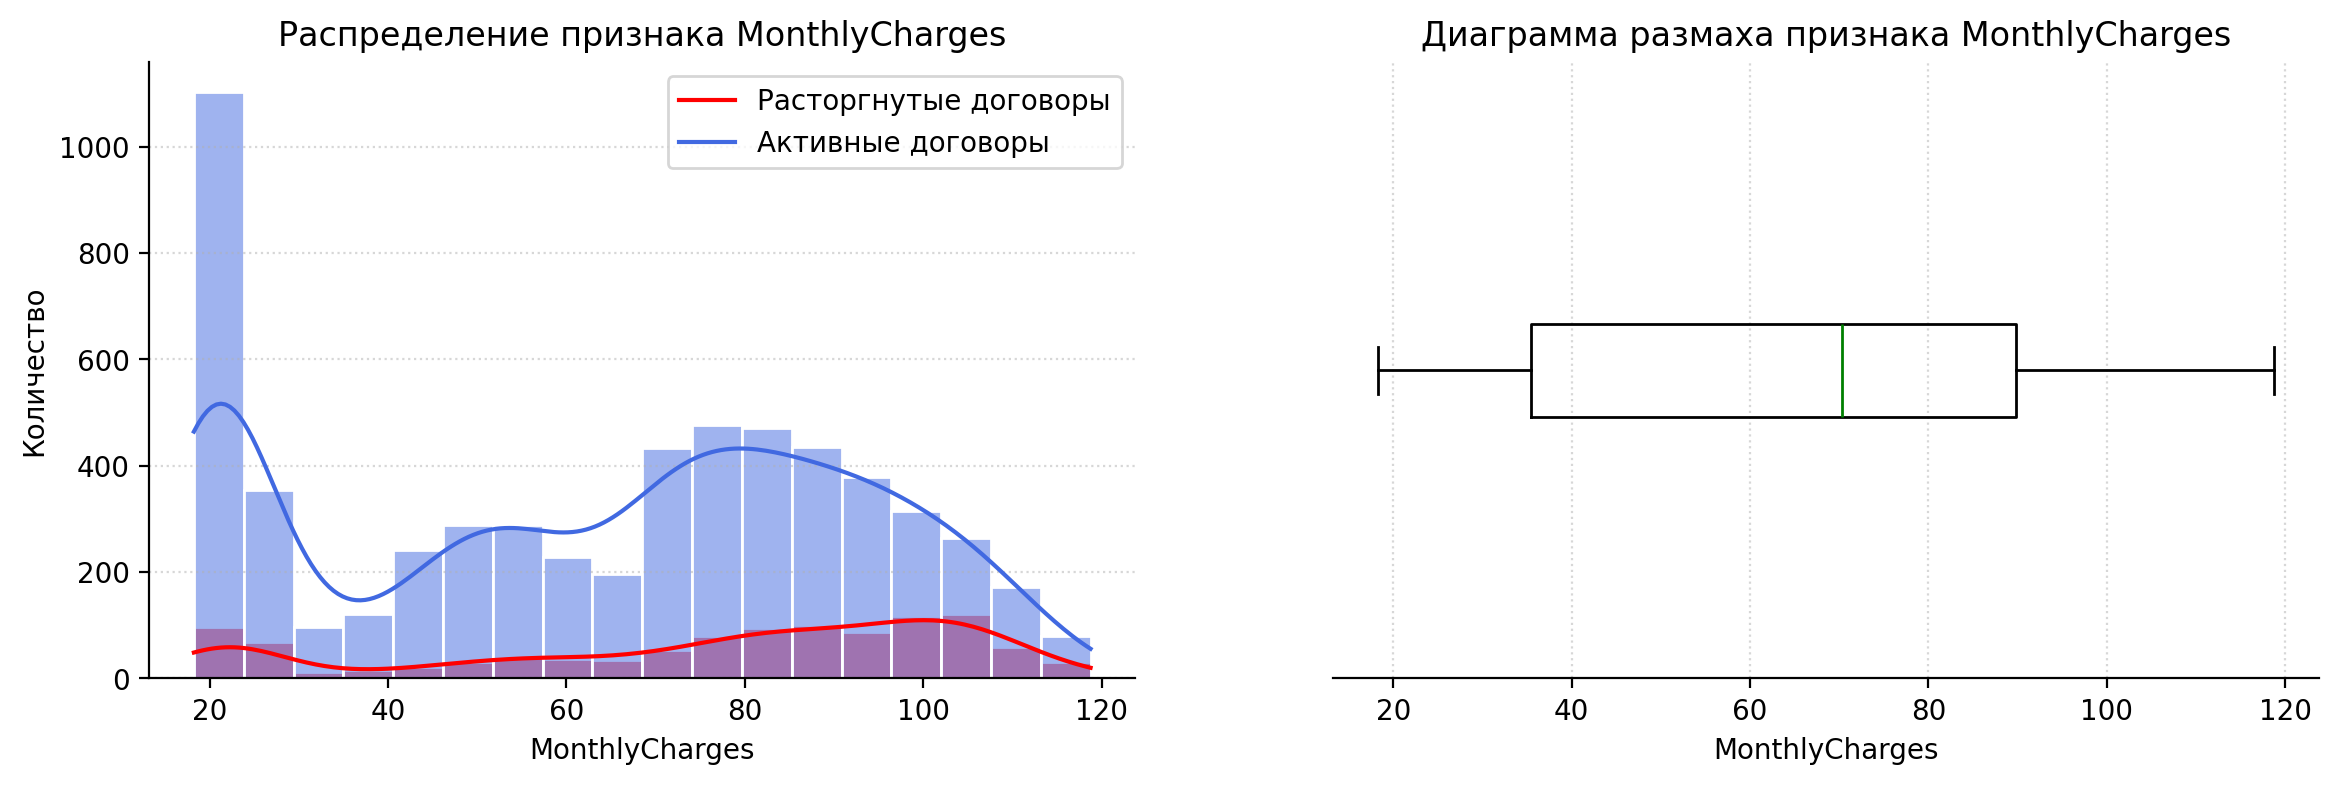

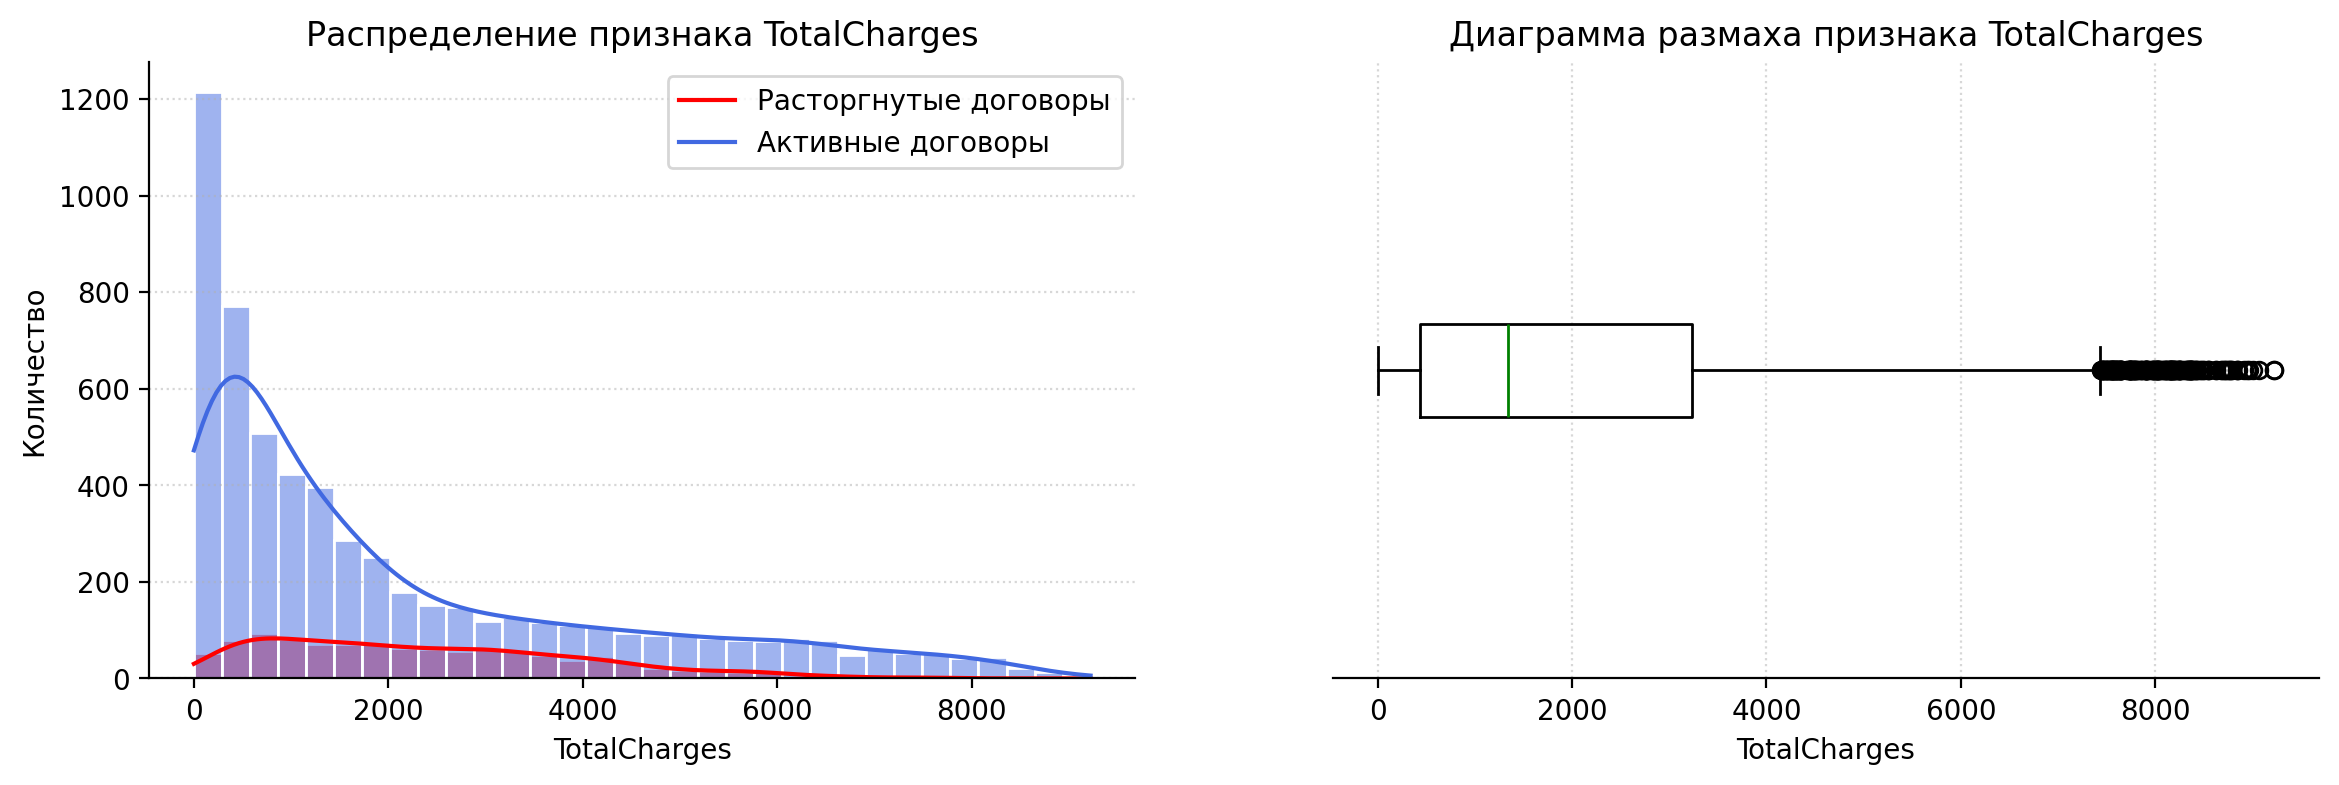

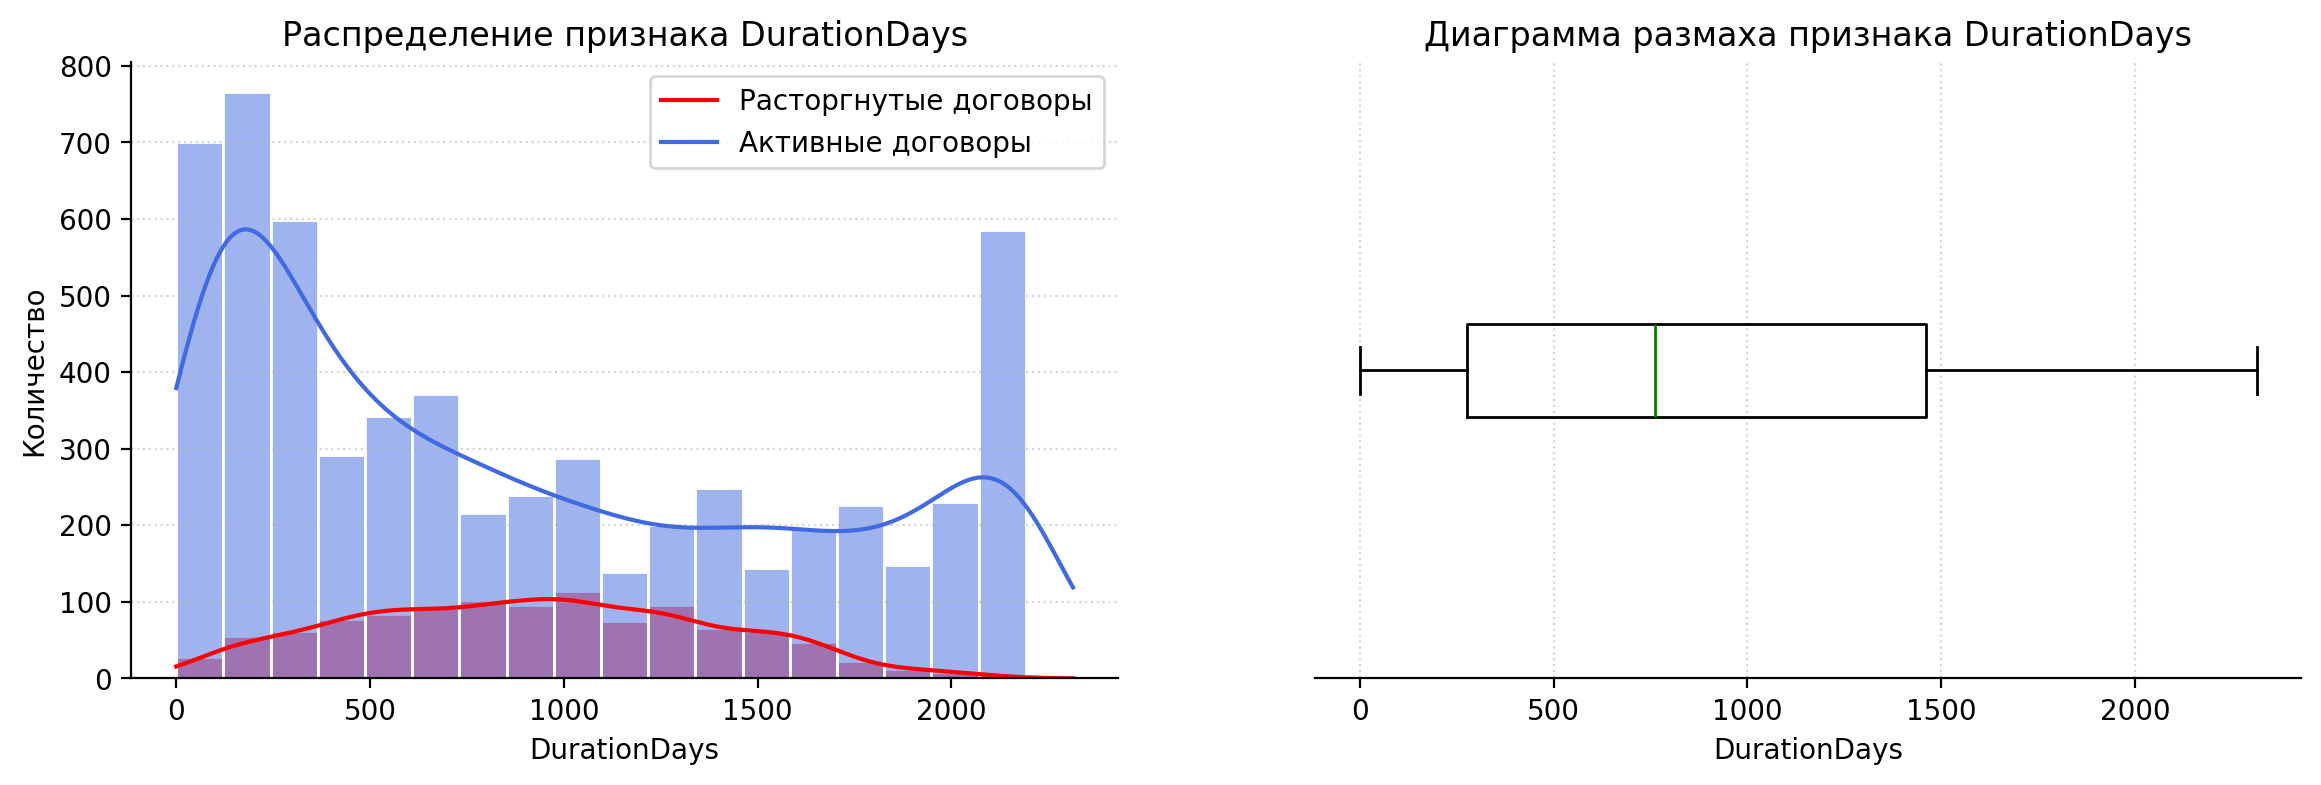

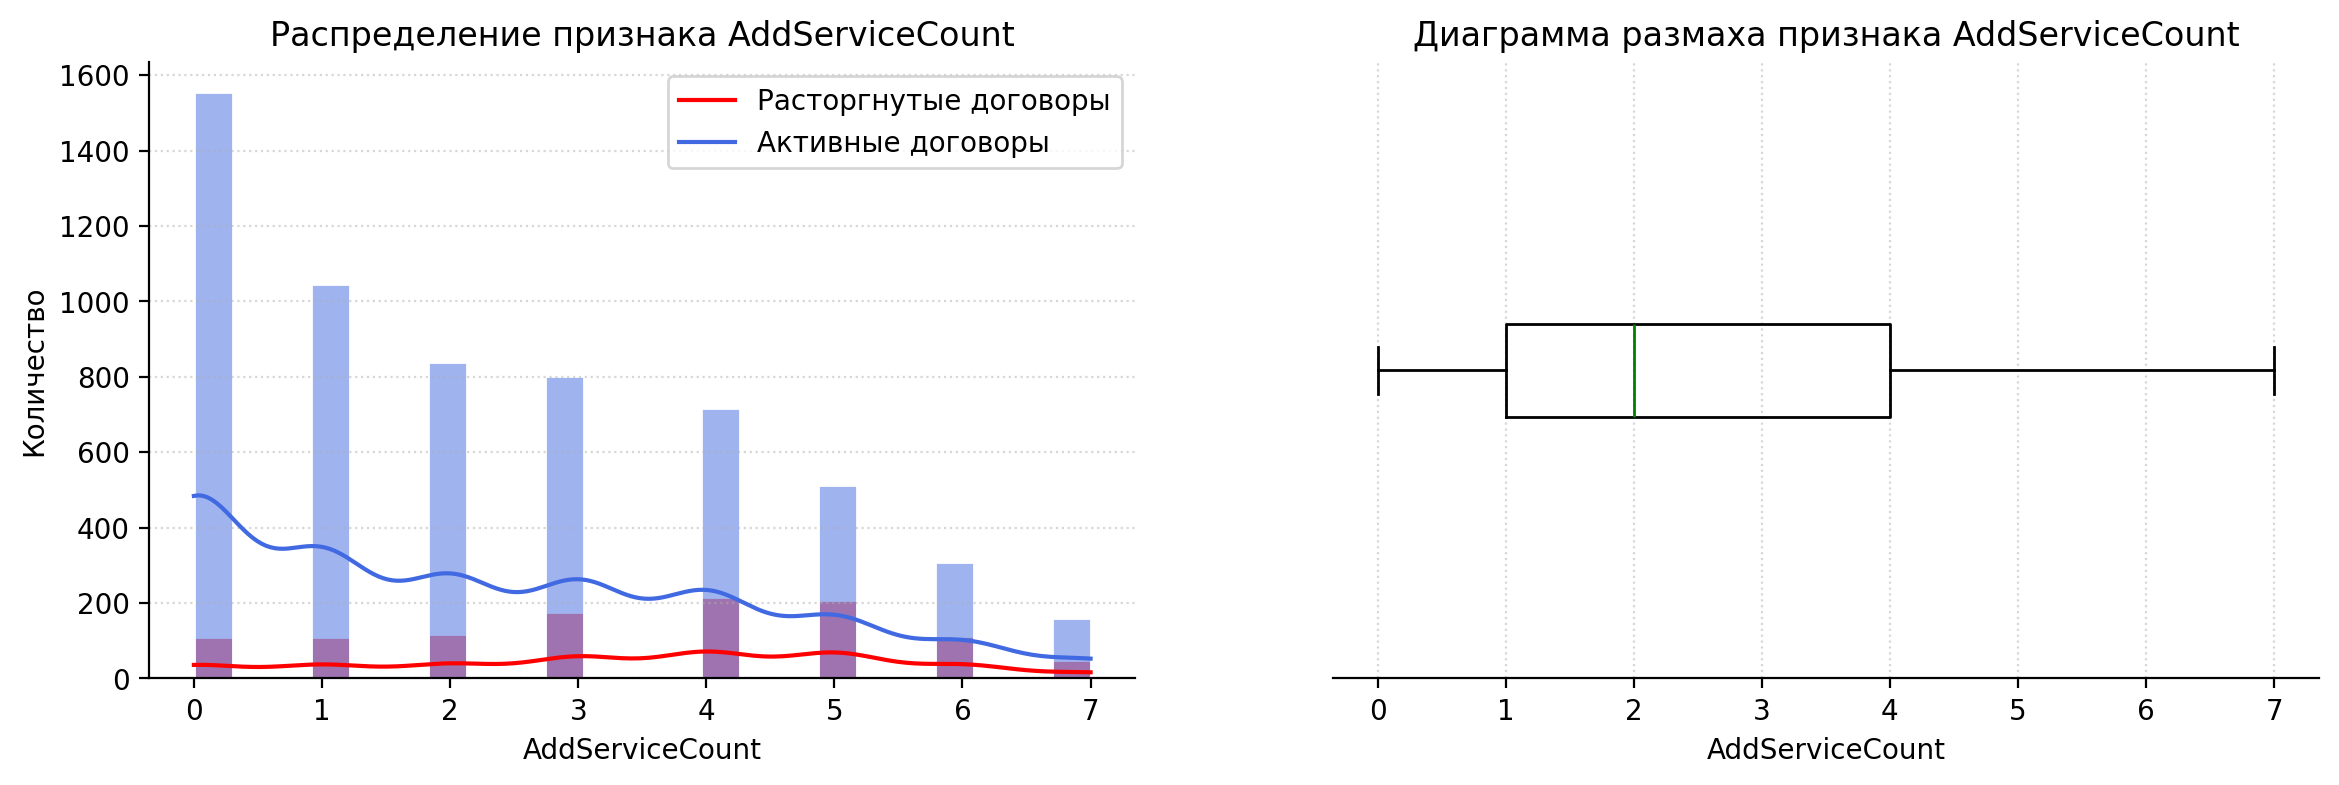

In [92]:
for column in num_columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    sns.histplot(
        x=union_df[column],
        hue=union_df['Reject'],
        hue_order=['No', 'Yes'],
        kde=True,
        kde_kws={'bw_method': 0.2},
        edgecolor='white',
        palette=['royalblue', 'red'],
        ax=ax1
    )
    ax1.set_title(f'Распределение признака {column}')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Количество')
    ax1.legend(labels=['Расторгнутые договоры', 'Активные договоры'])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(axis='y', alpha=0.5, linestyle=':')

    union_df[column].plot(
        kind='box', vert=False, color='black', medianprops={'color': 'green'}, ax=ax2
    )
    ax2.set_title(f'Диаграмма размаха признака {column}')
    ax2.set_xlabel(column)
    ax2.set_yticklabels([])
    ax2.set_yticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.grid(axis='x', alpha=0.5, linestyle=':')

    plt.show()

Можно отметить, что:
- аномальных значений и сильных выбросов в количественных признаках не обнаружено;
- количественные признаки распределены не нормально;
- распределения признака с длительностью договора `DurationDays` в разбивке по таргету сильно отличаются друг от друга.
- распределения признака с количеством подключенных дополнительных услуг `AddServiceCount` в разбивке по таргету сильно отличаются друг от друга.

### Категориальные признаки

Посмотрим на числовое описание категориальных признаков.

In [96]:
cat_columns = union_df.select_dtypes(exclude=np.number).columns.drop('Reject')
union_df[cat_columns].describe().T

,count,unique,top,freq
Type,7043,3,Month-to-month,3875
PaperlessBilling,7043,2,Yes,4171
PaymentMethod,7043,4,Electronic check,2365
Gender,7043,2,Male,3555
SeniorCitizen,7043,2,No,5901
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088


Изучим распределения категориальных признаков, а также долю разорванных договоров при различных значениях этих признаков.

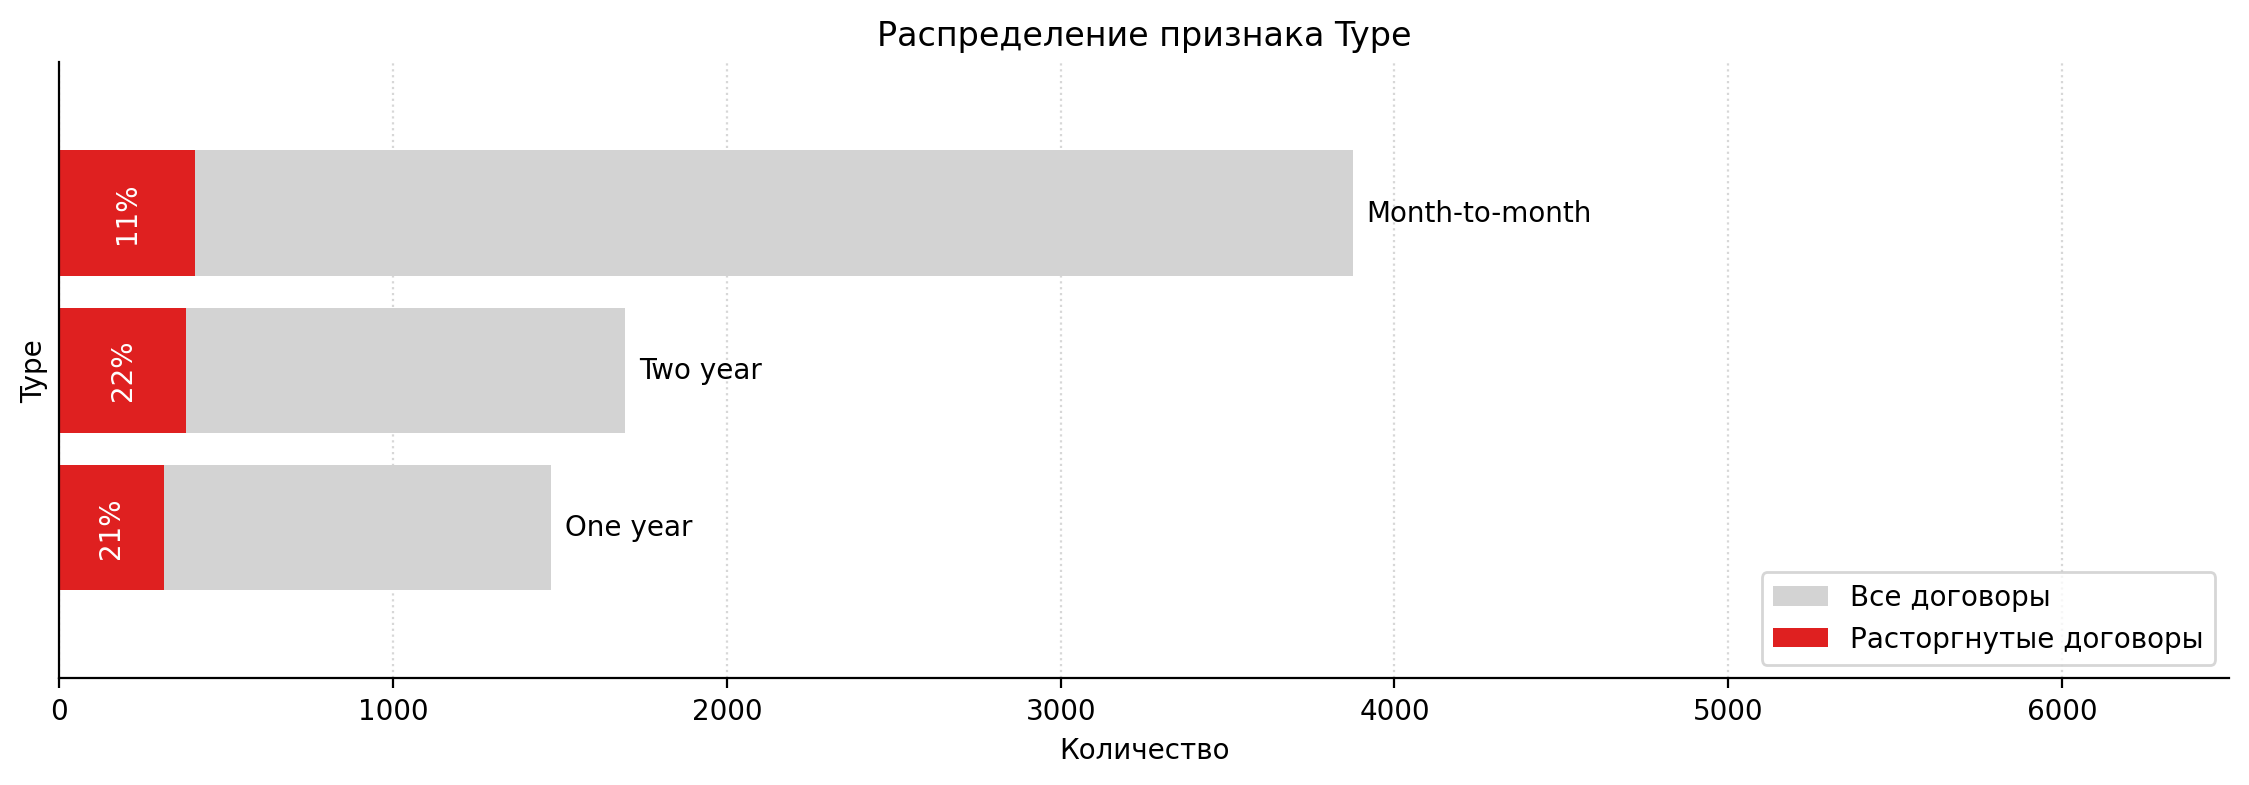

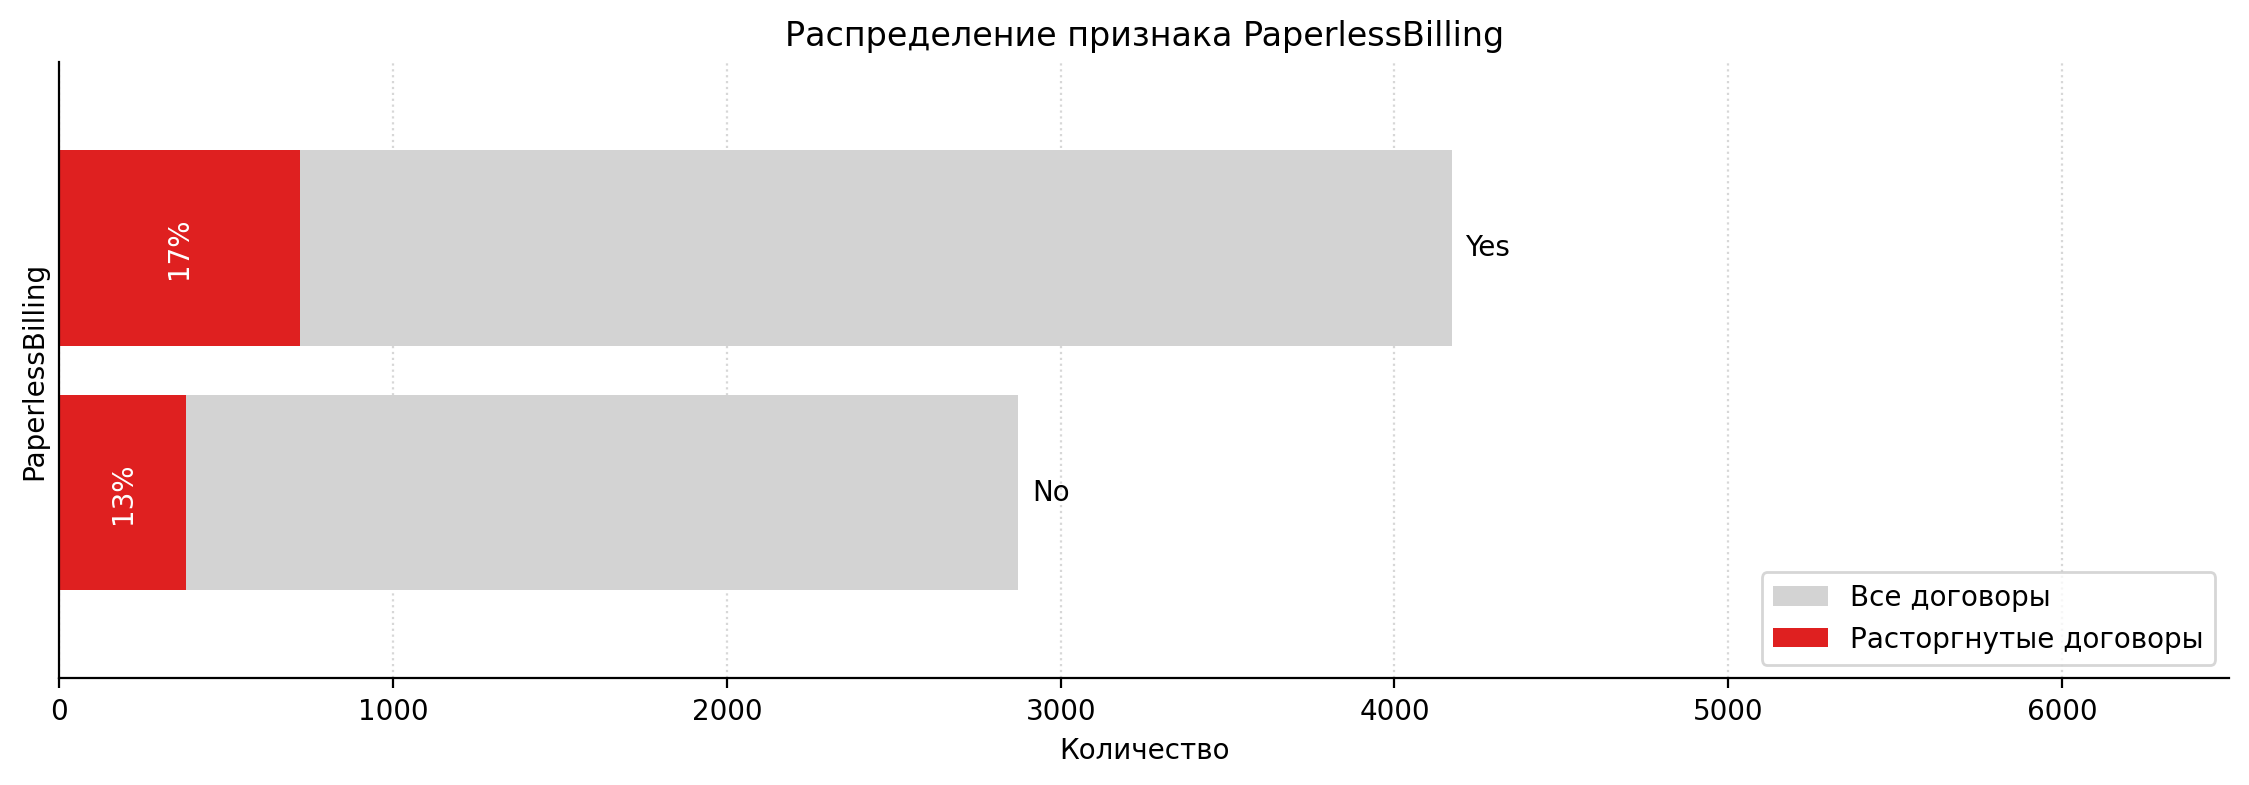

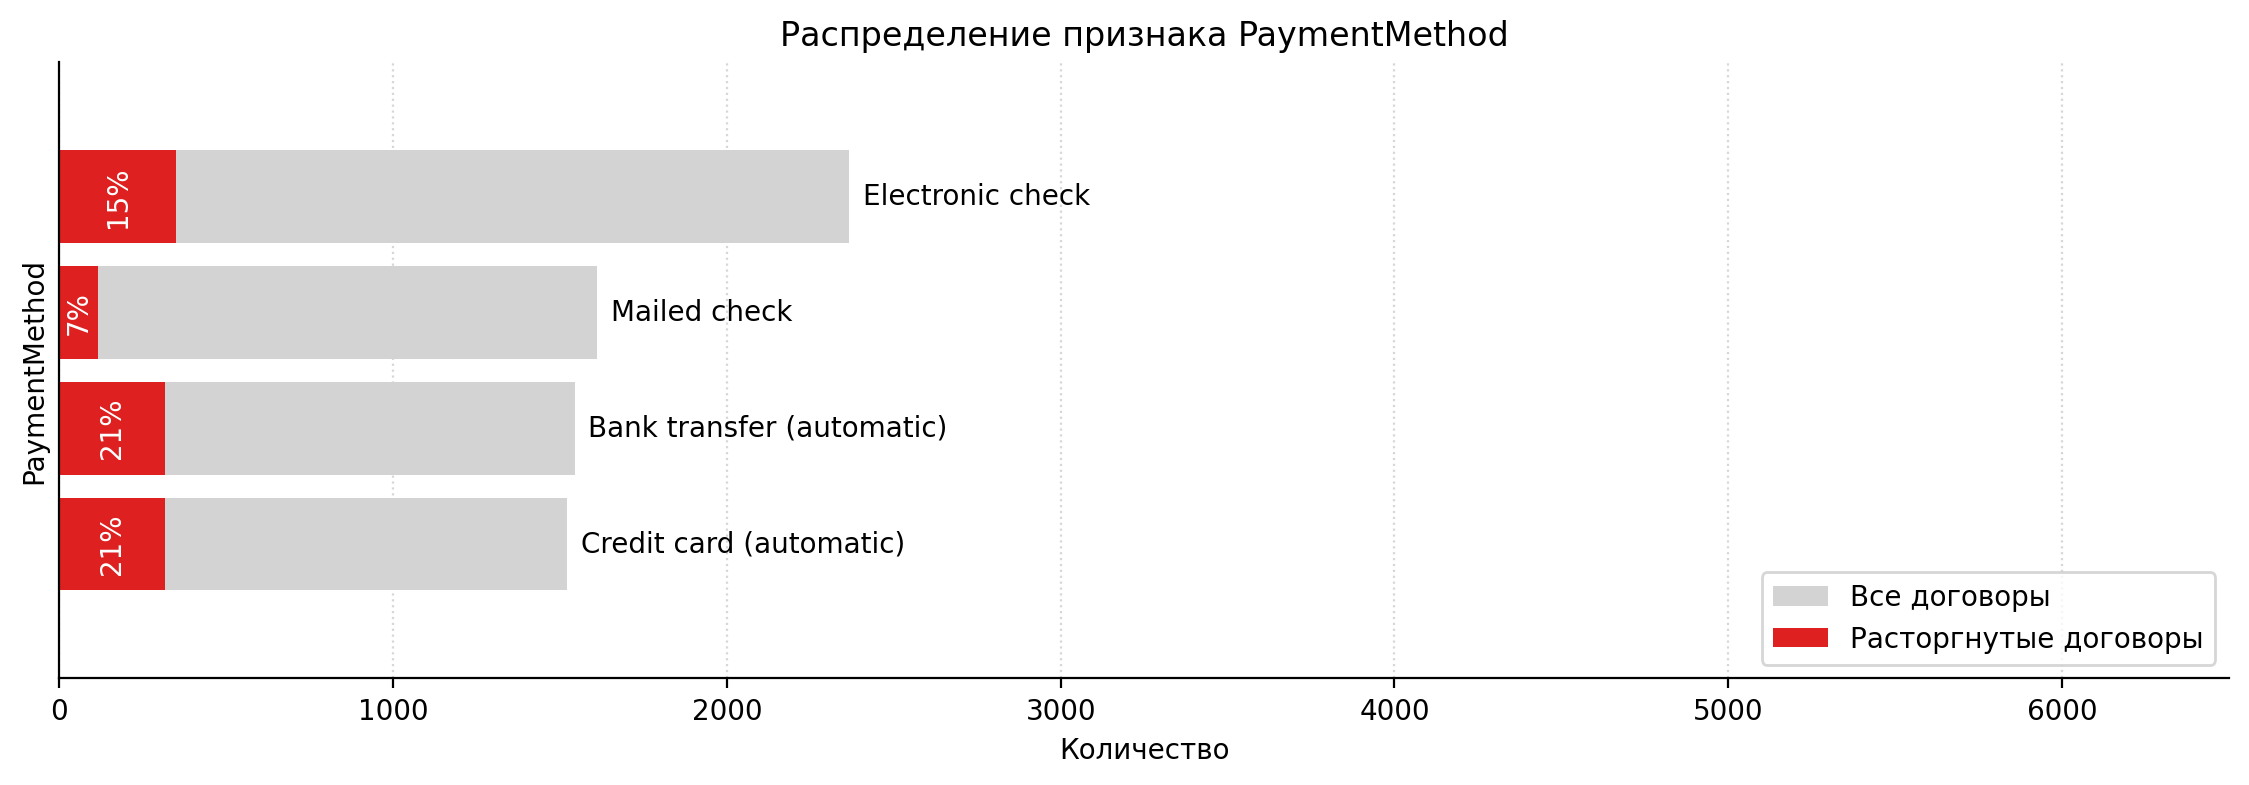

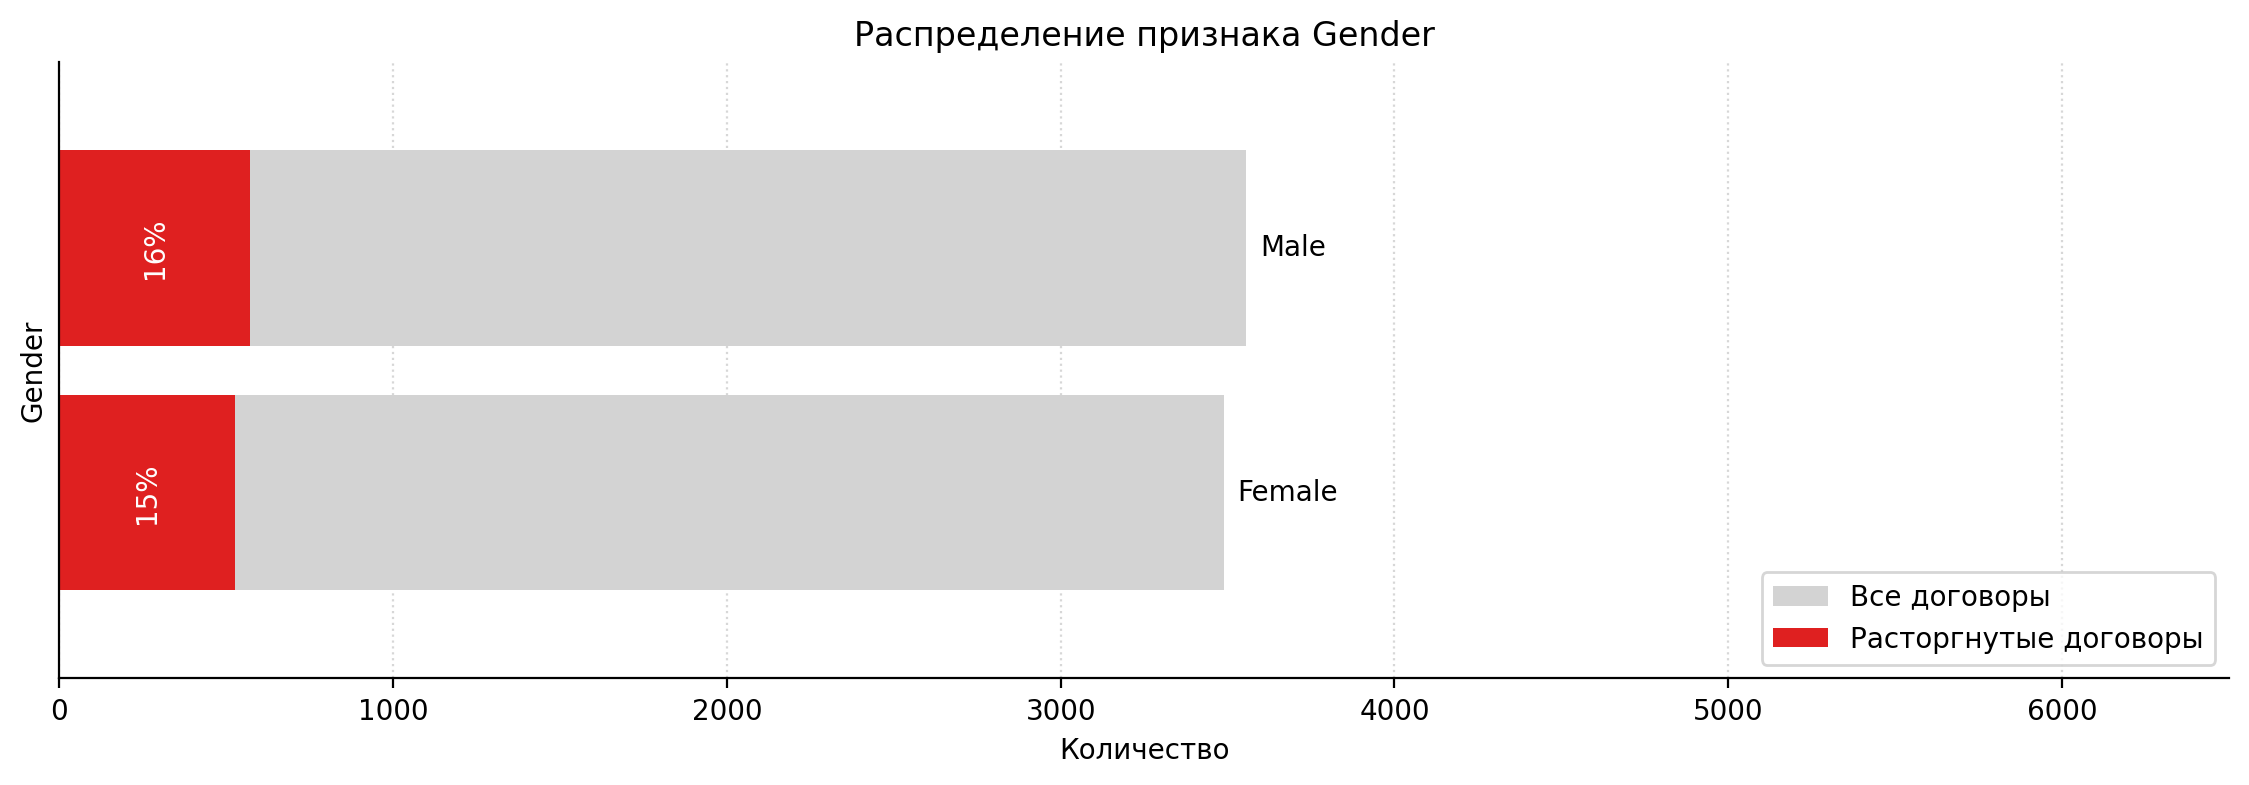

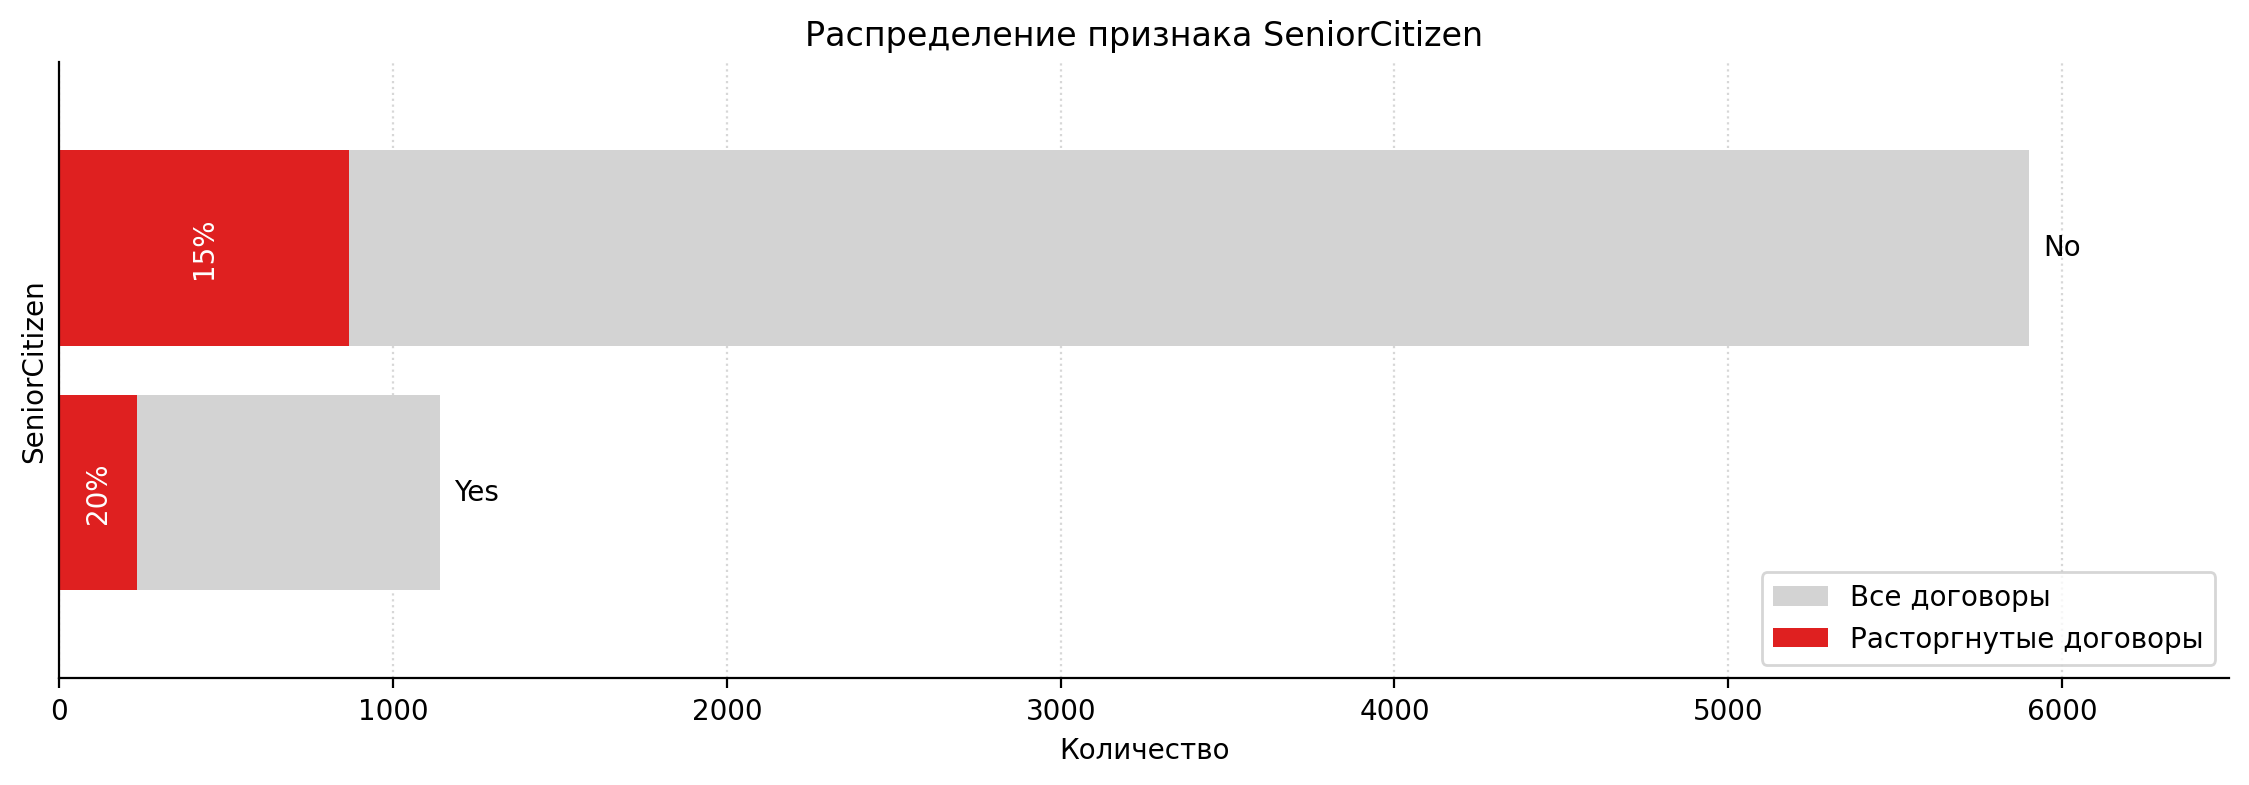

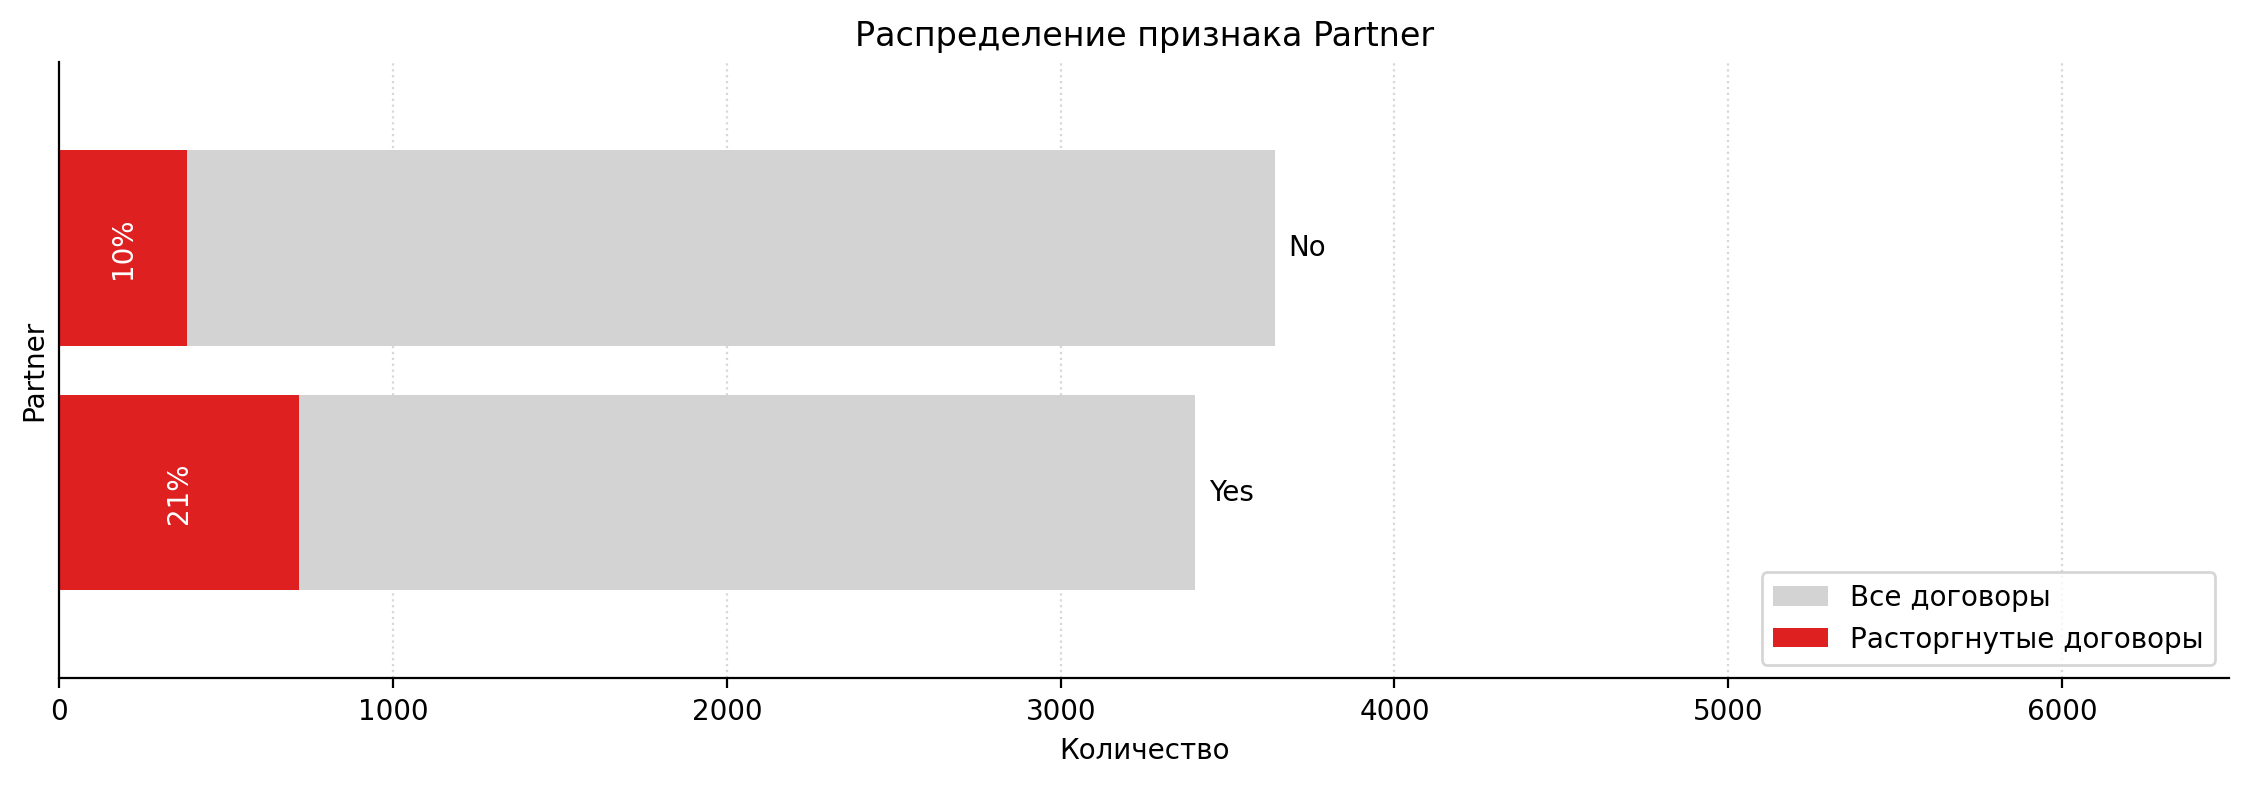

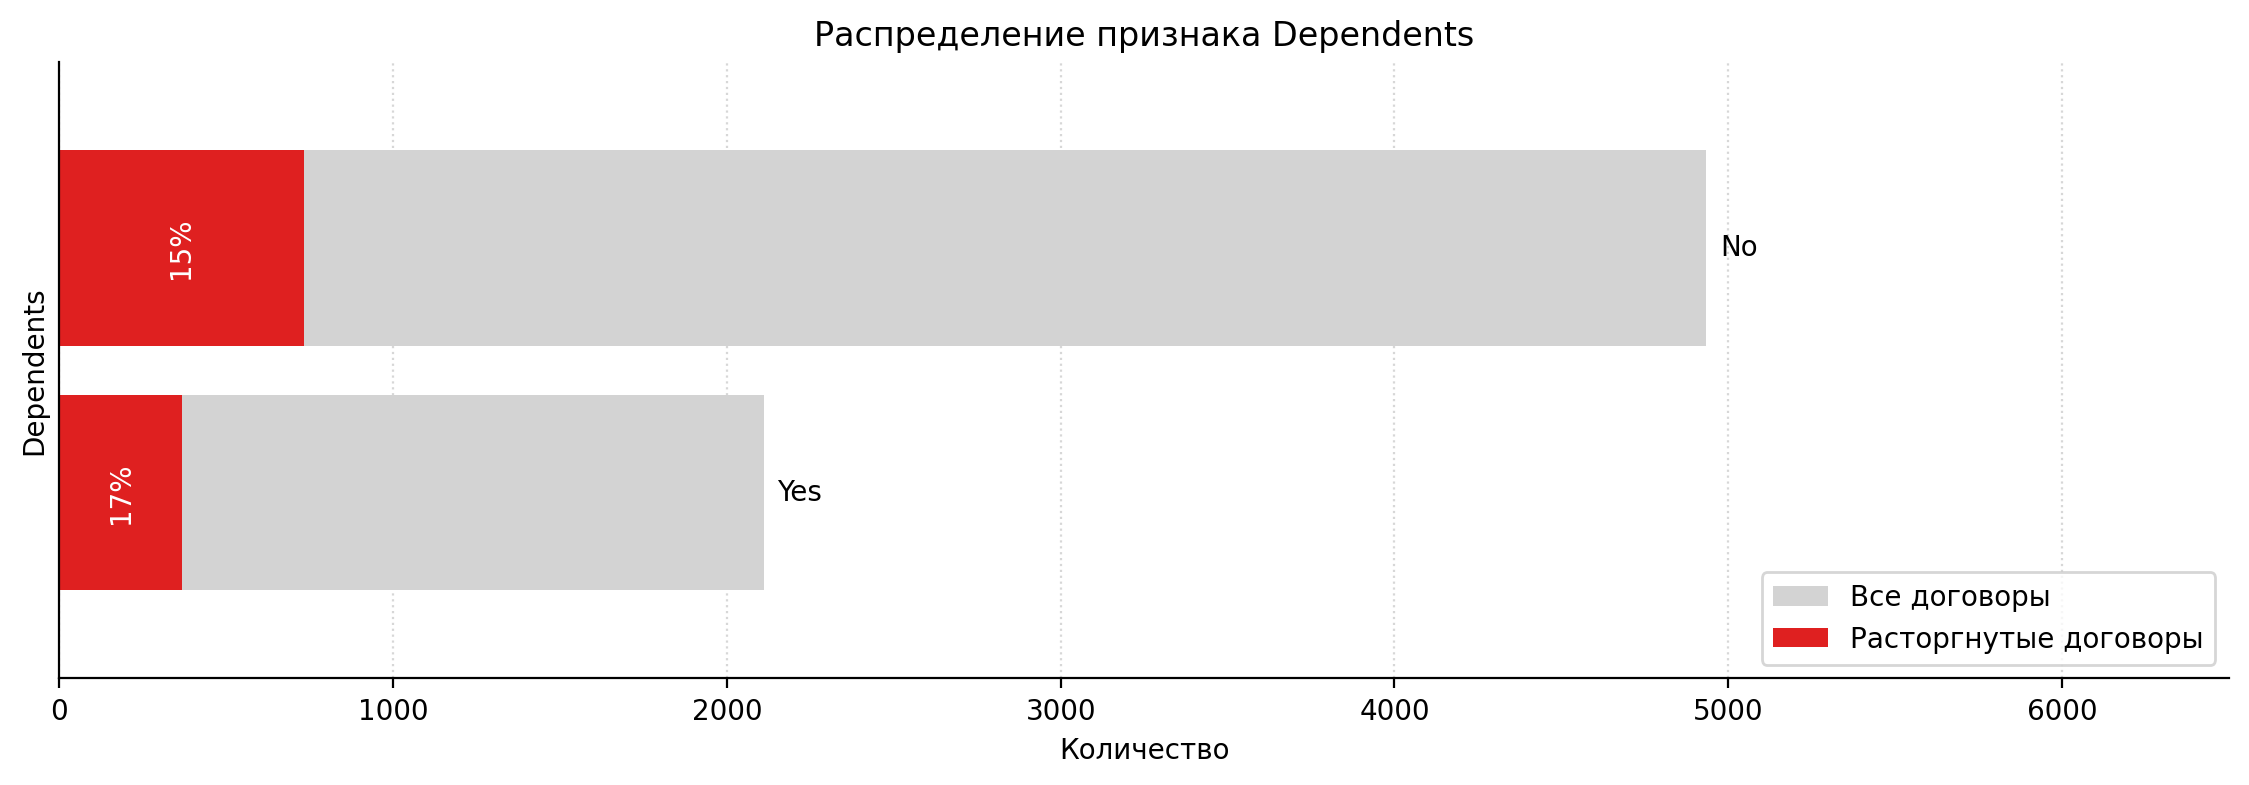

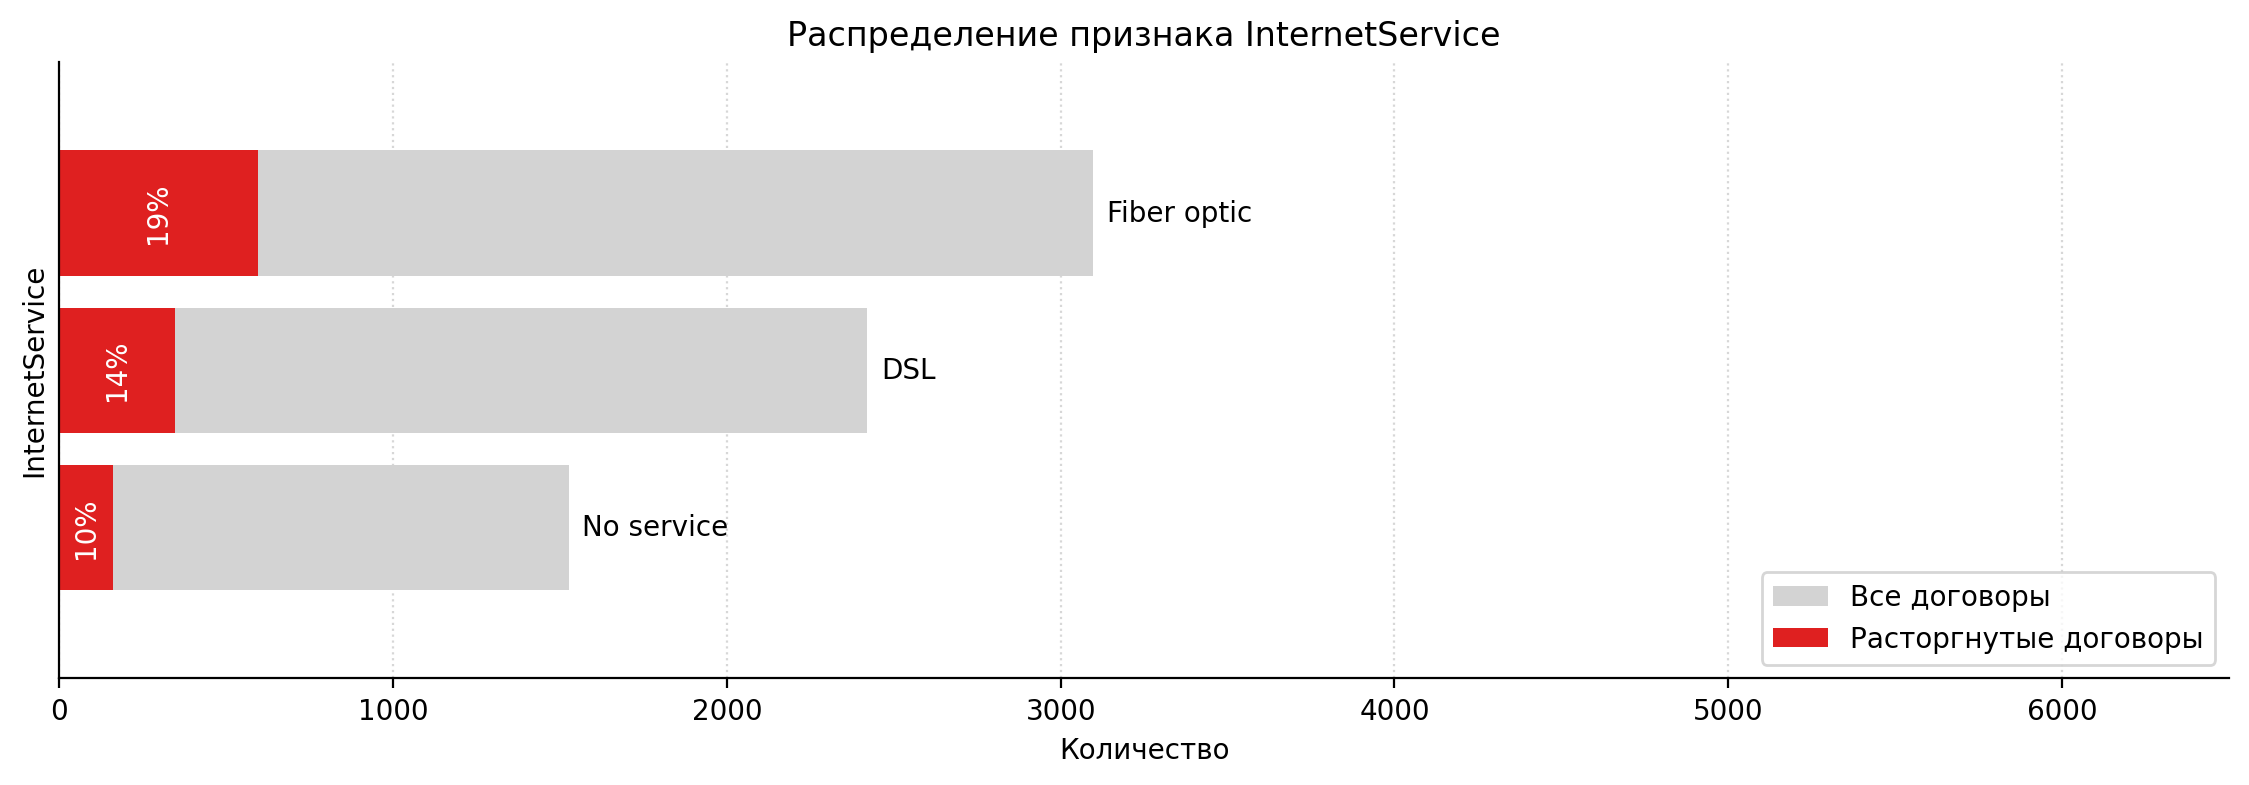

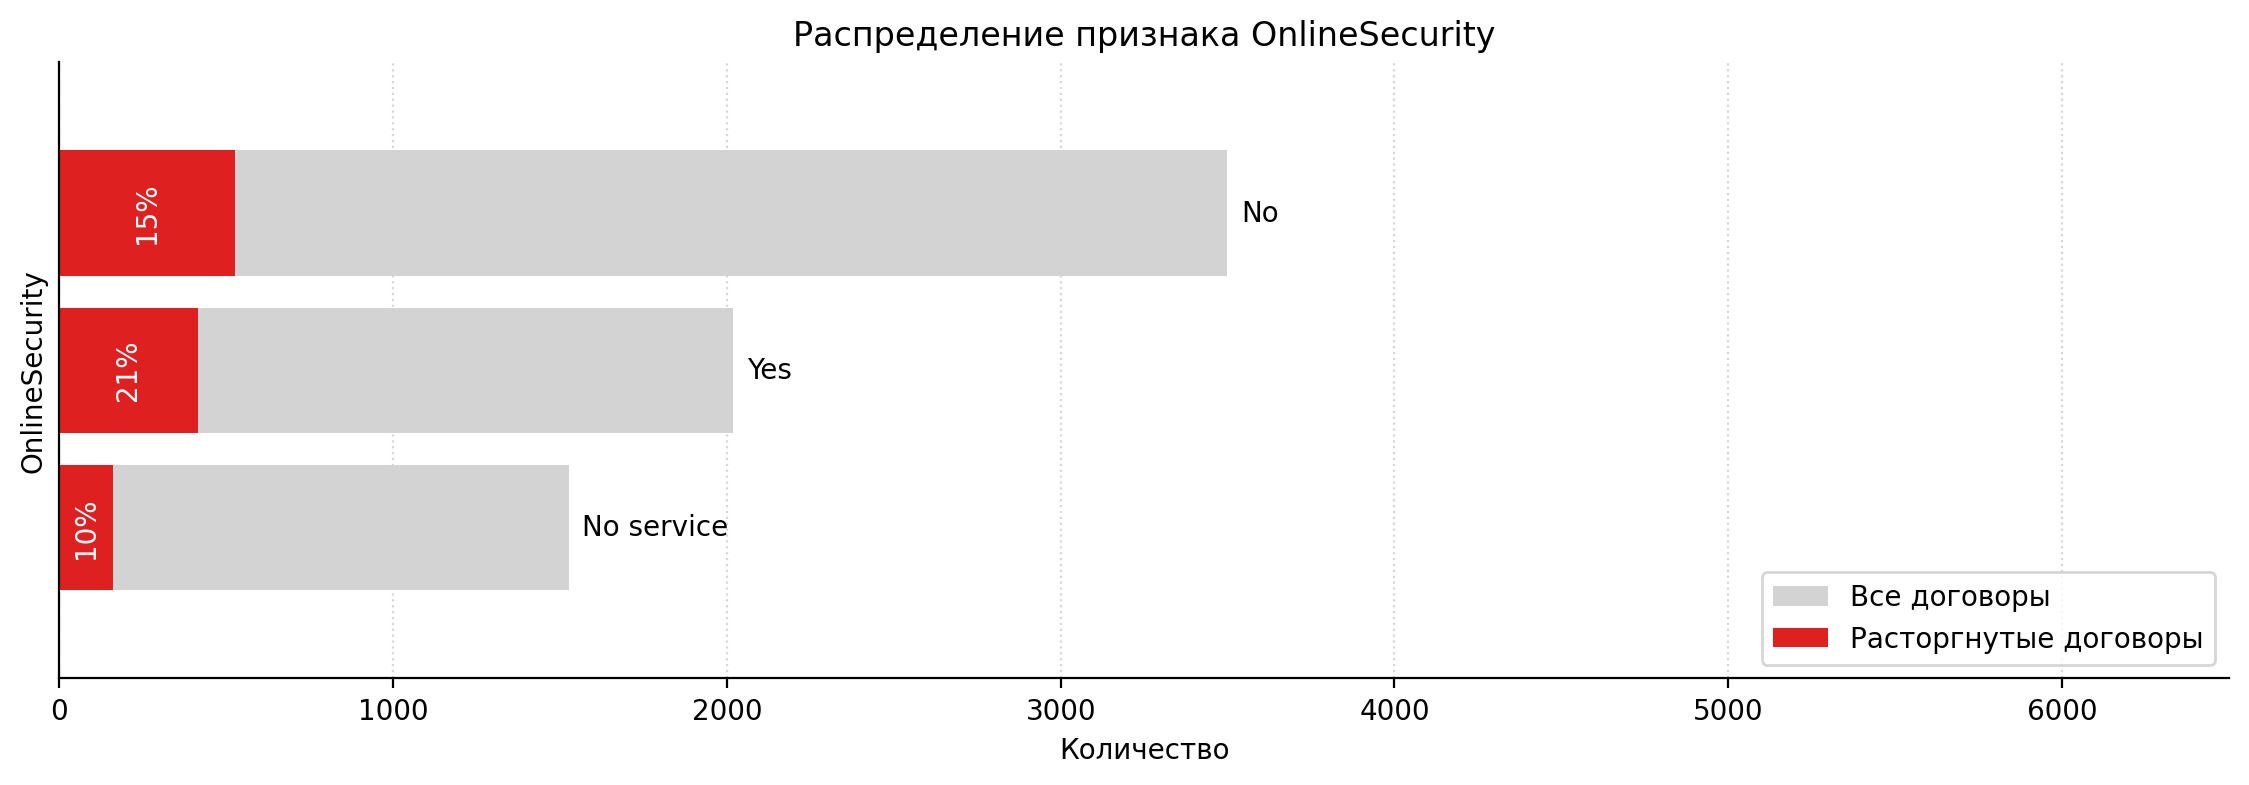

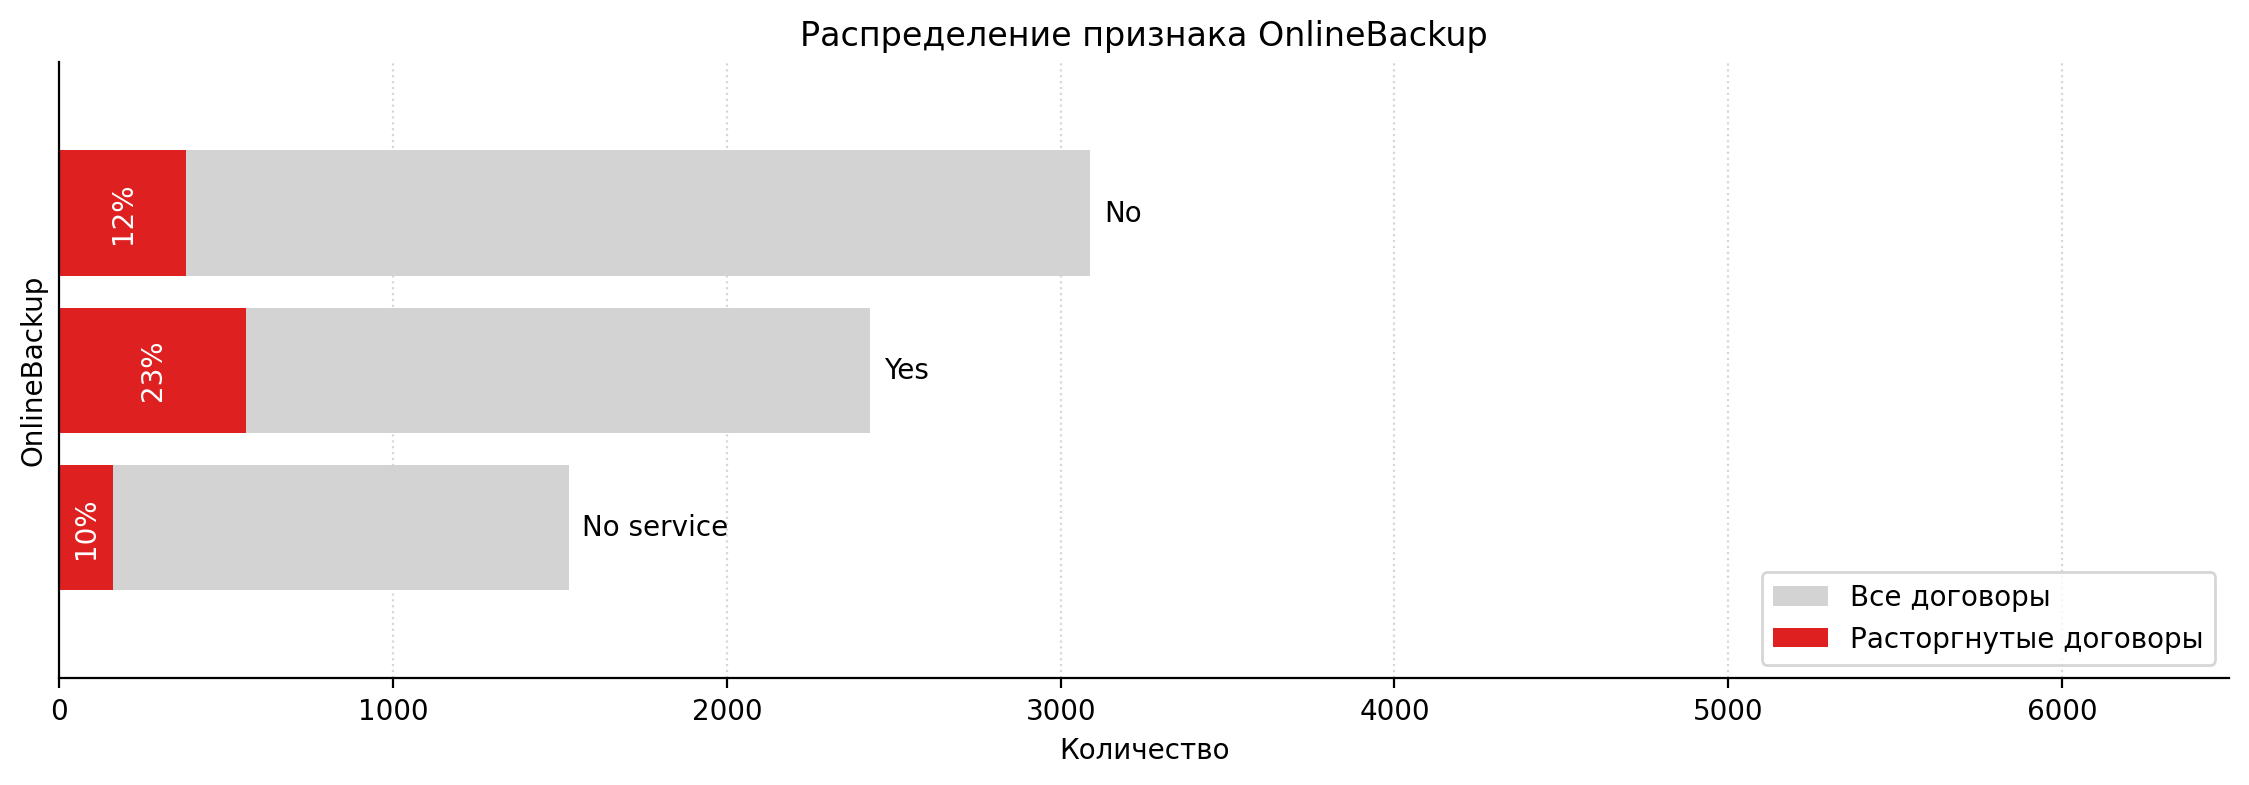

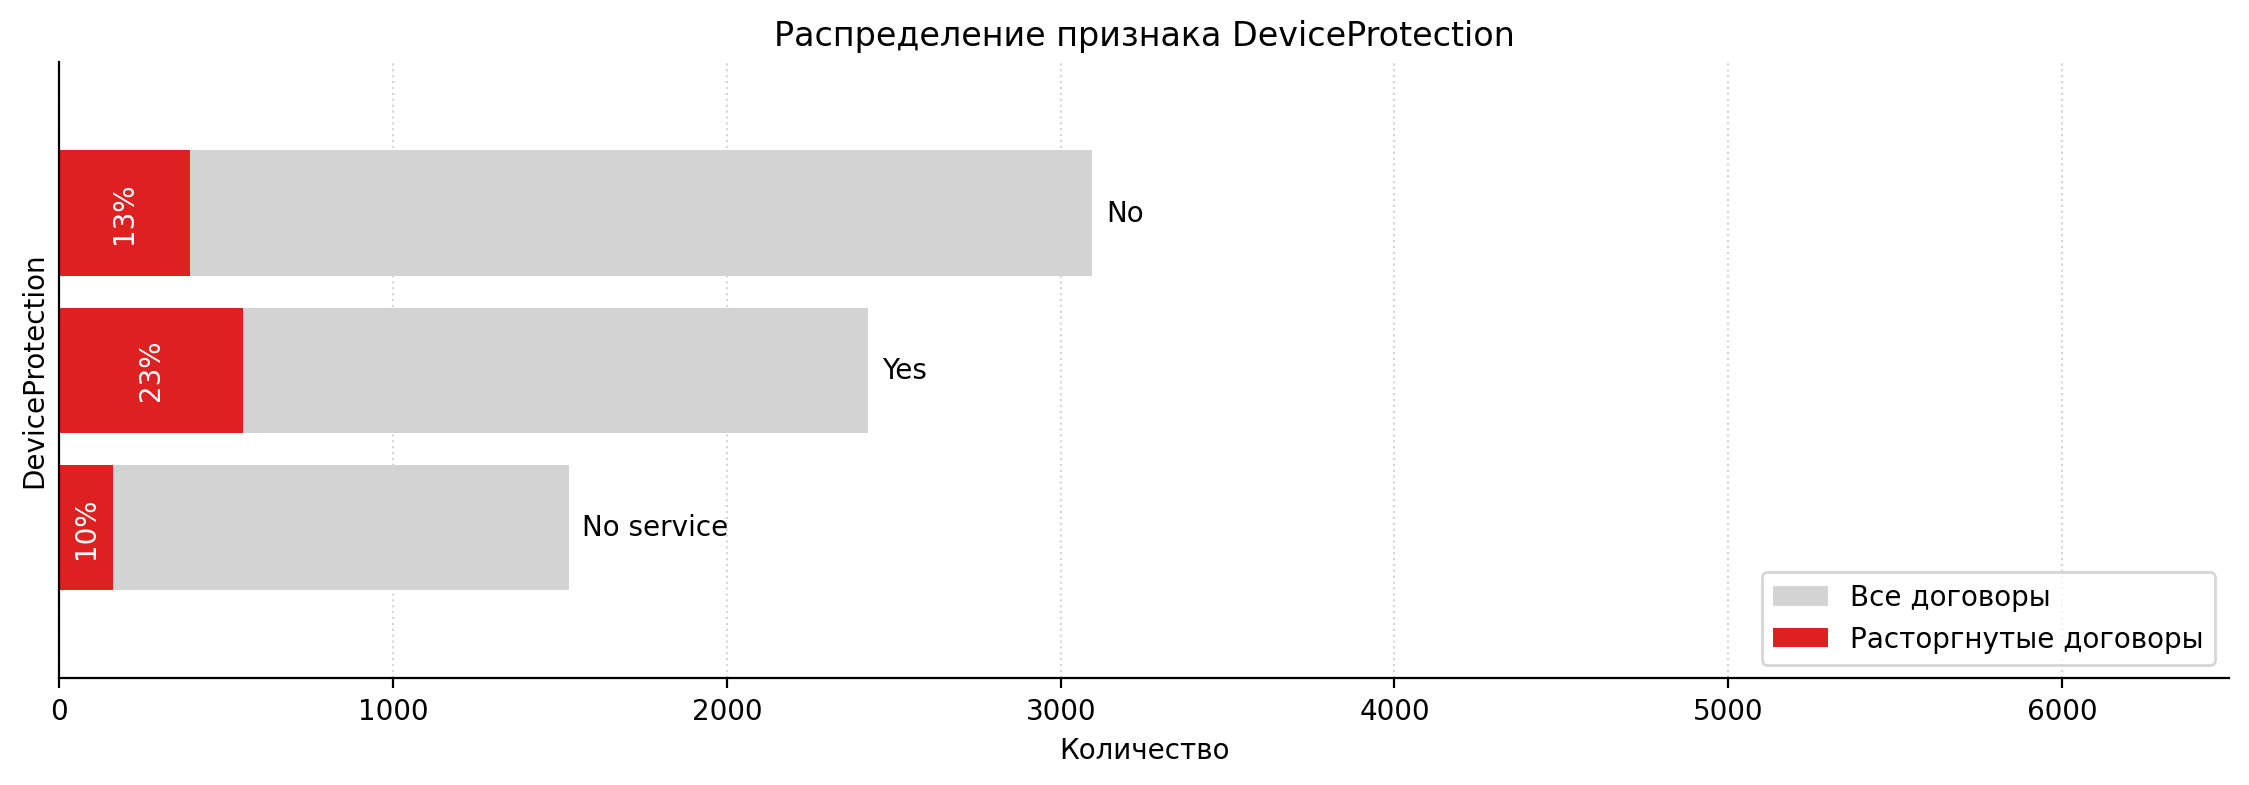

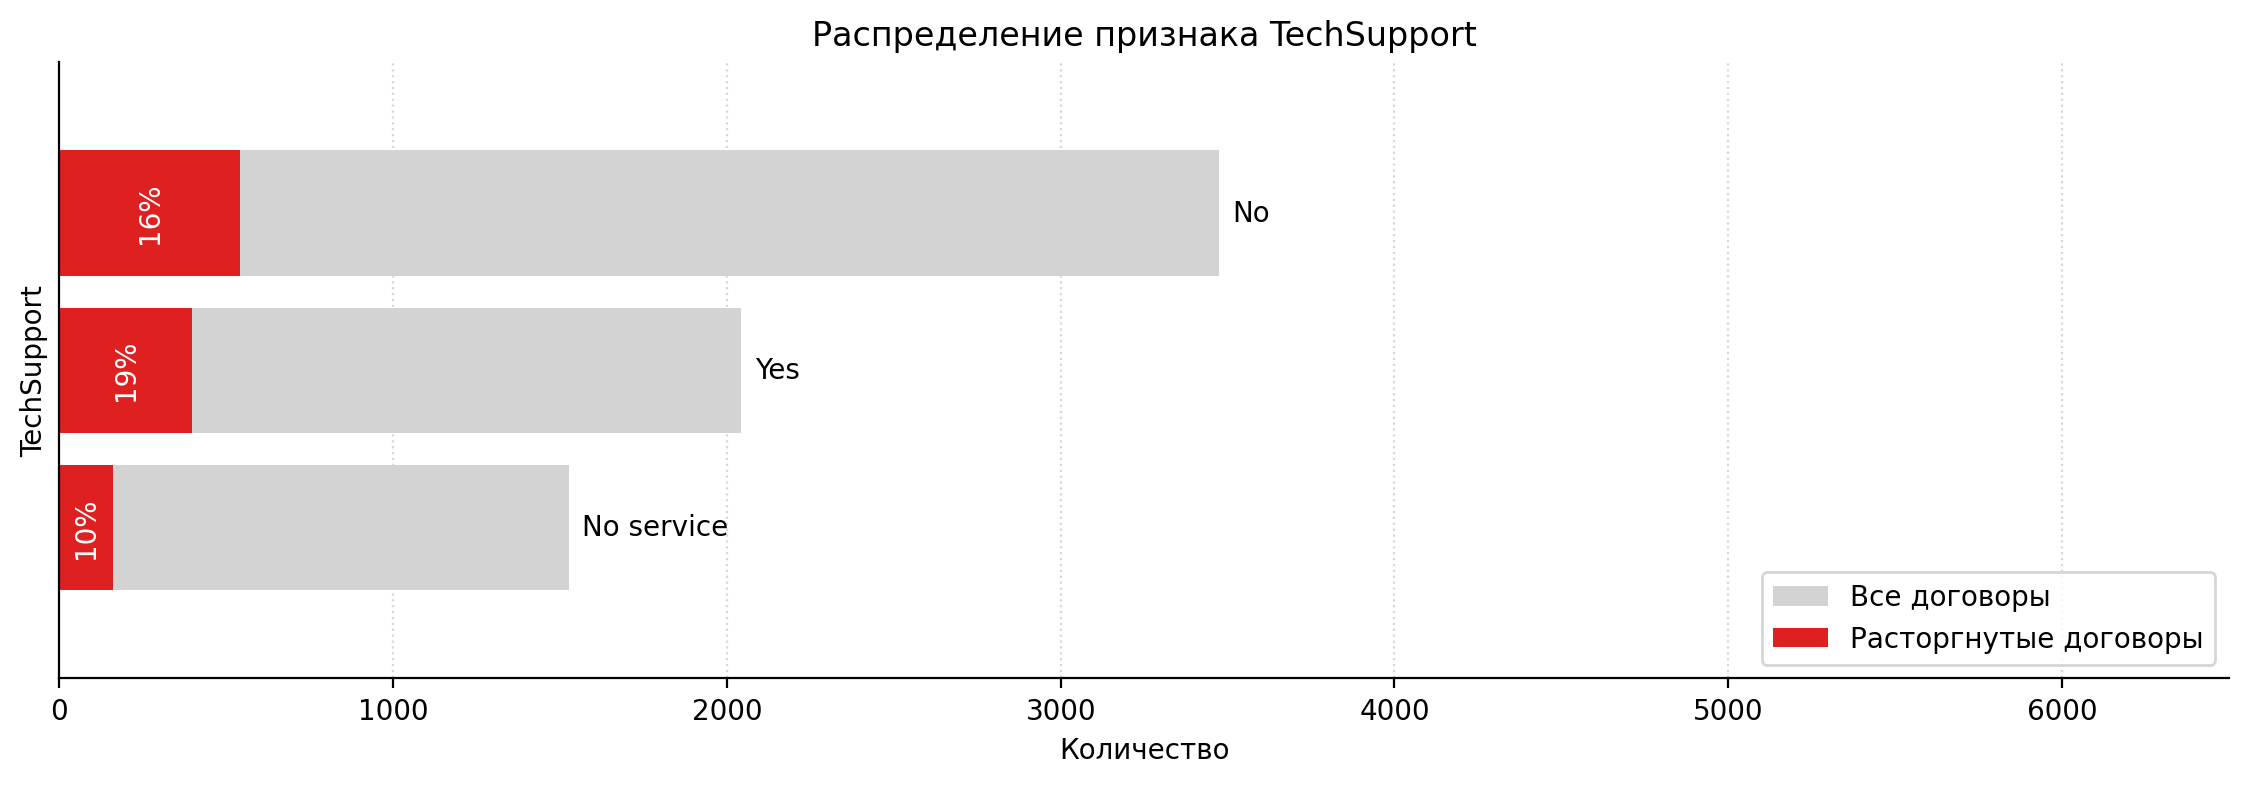

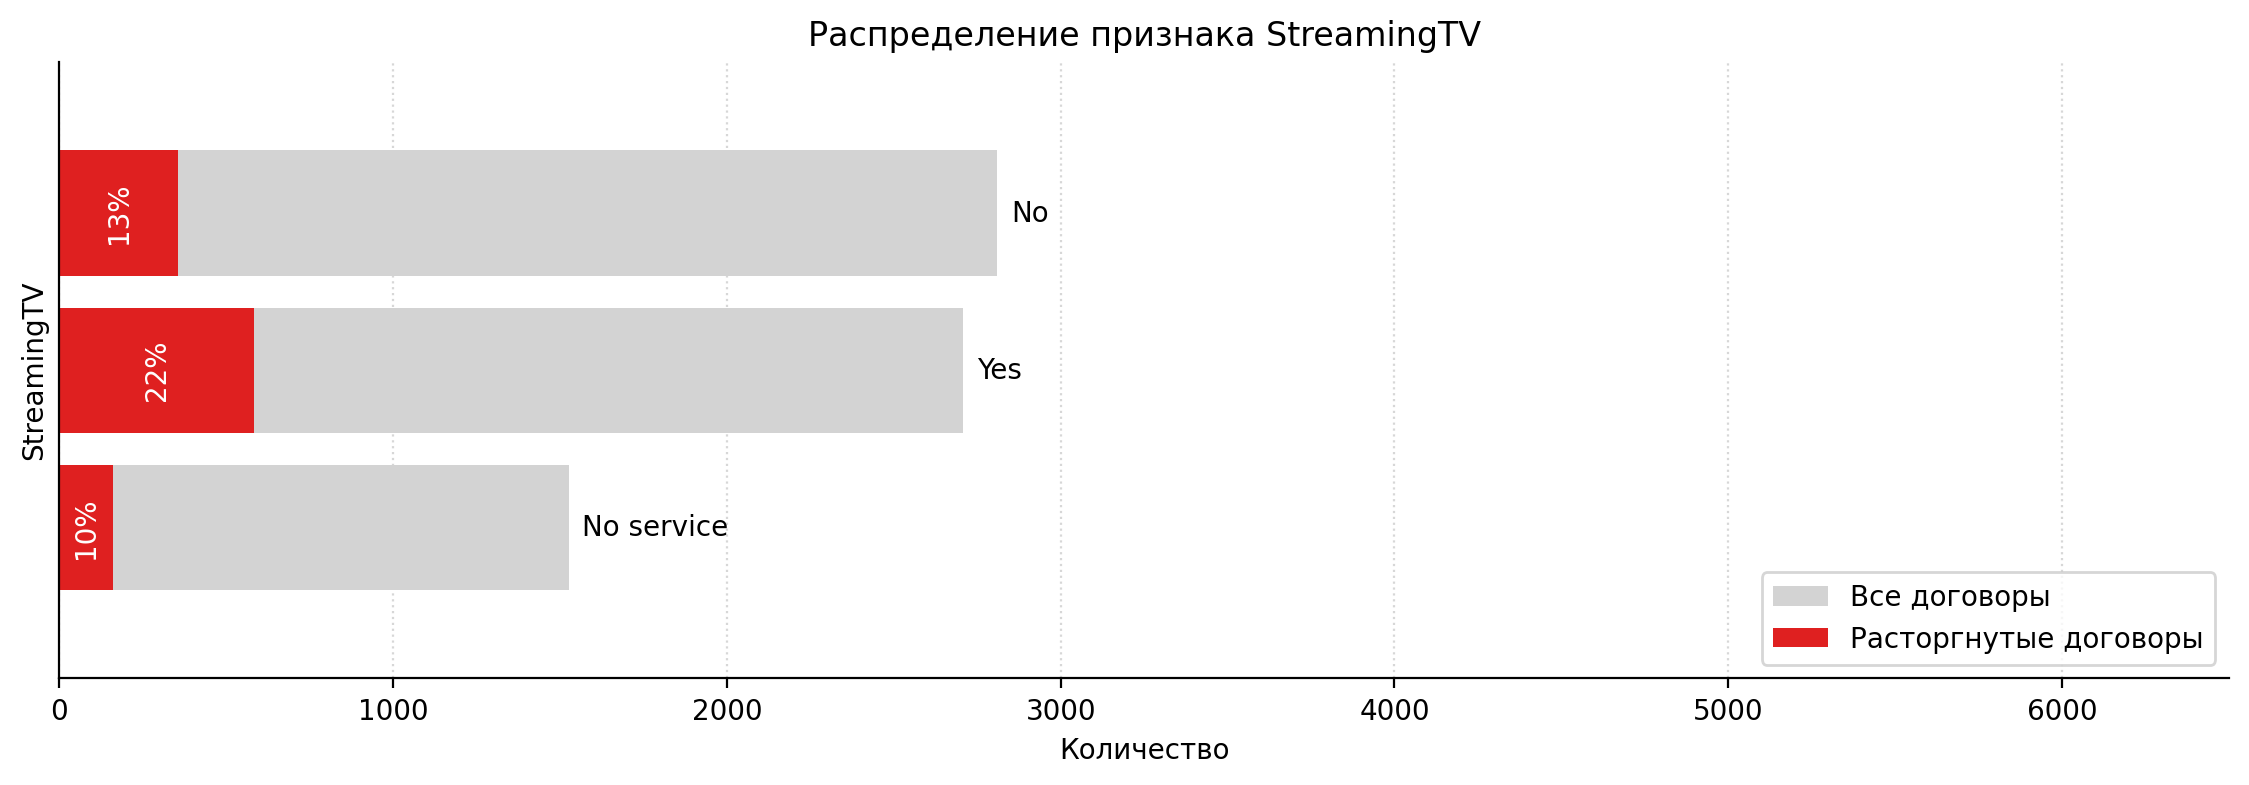

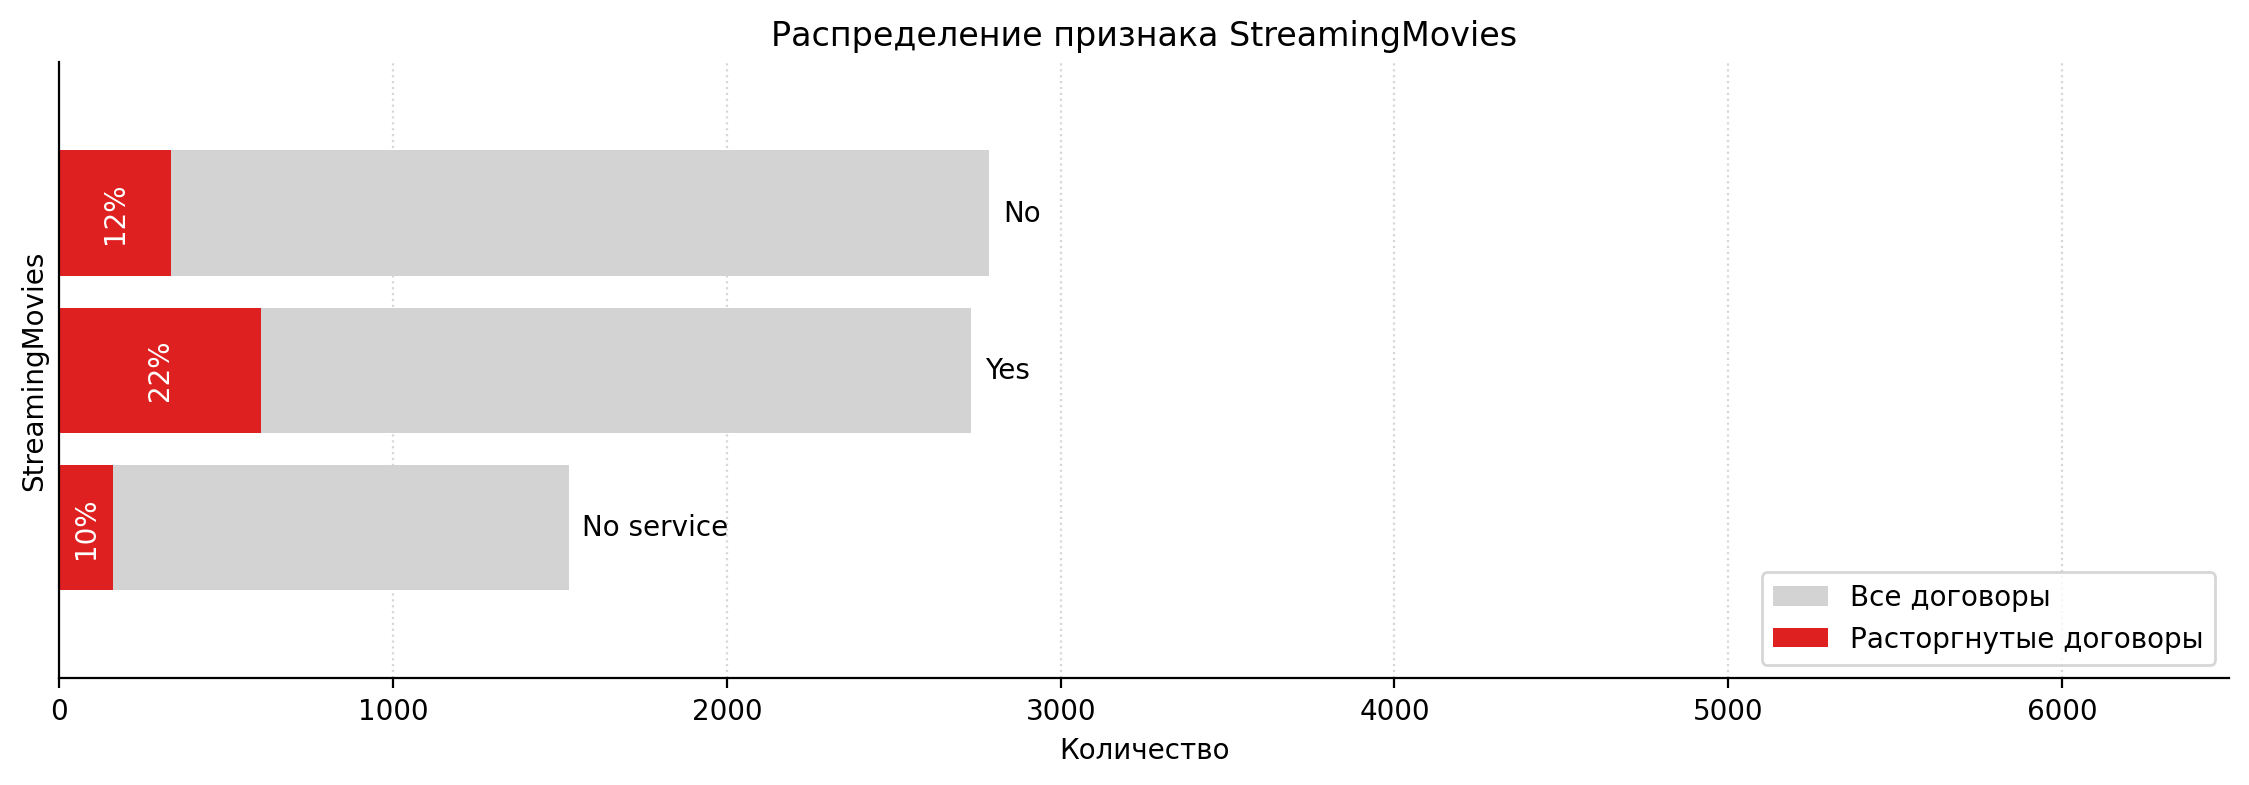

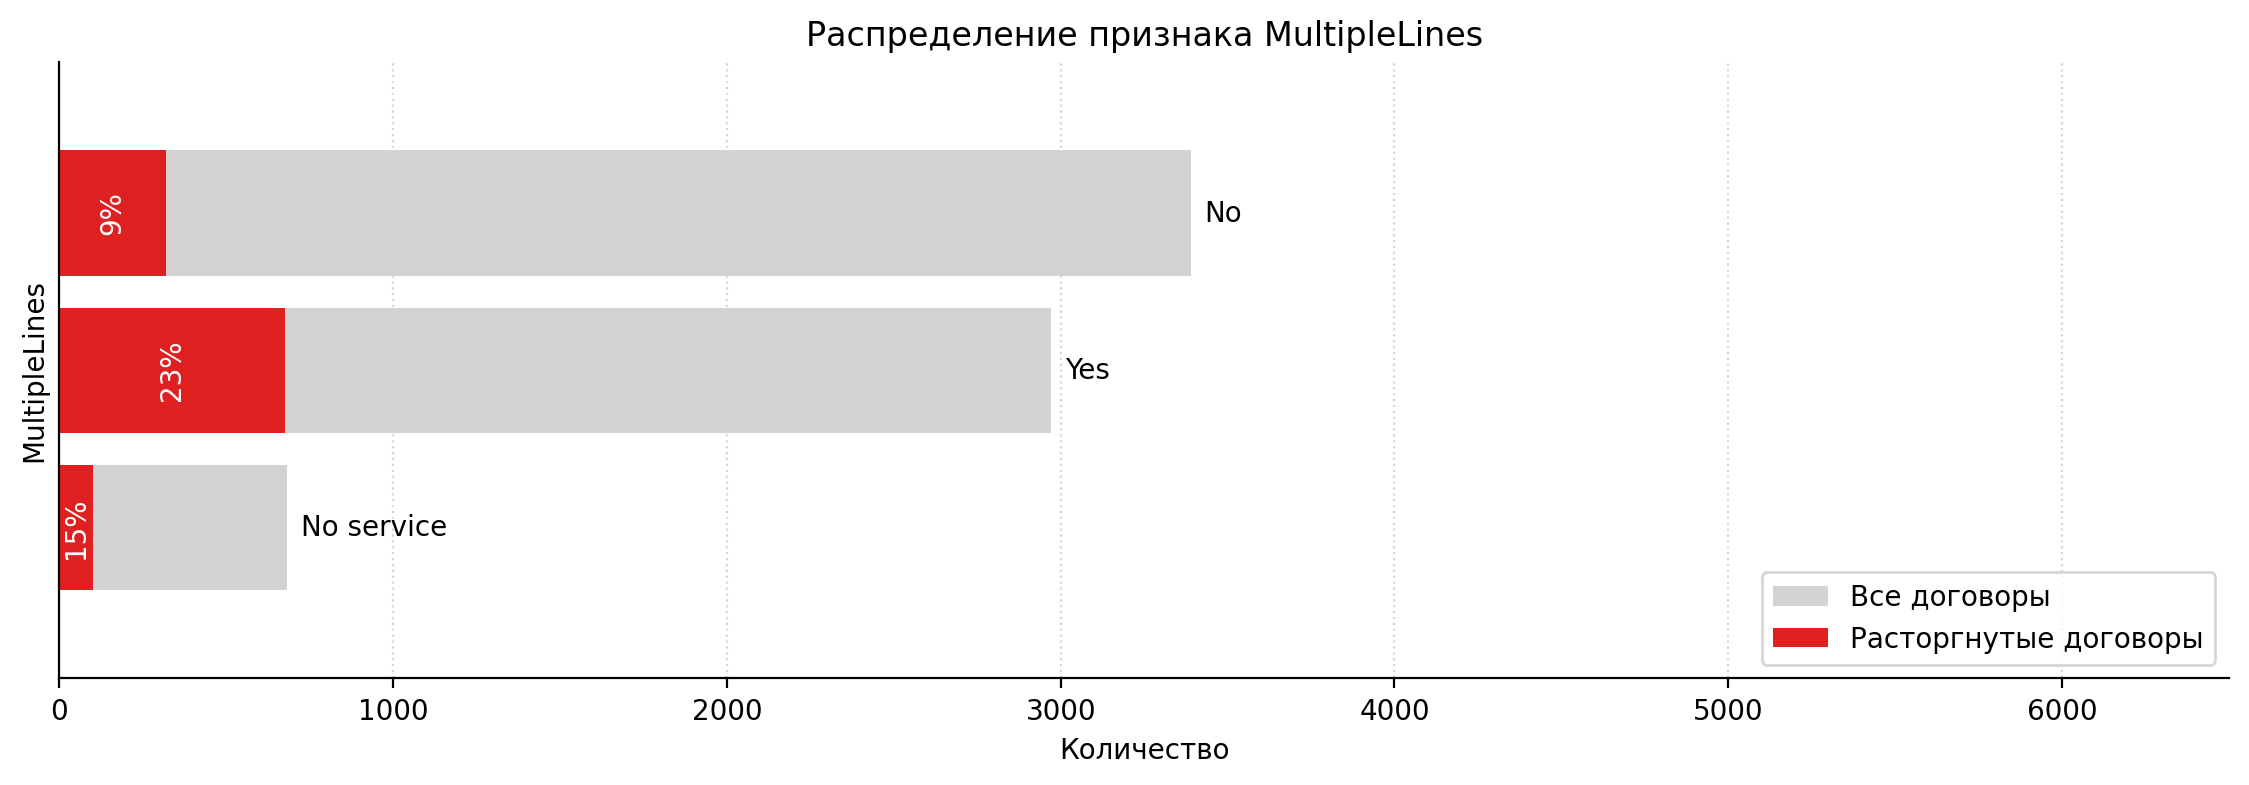

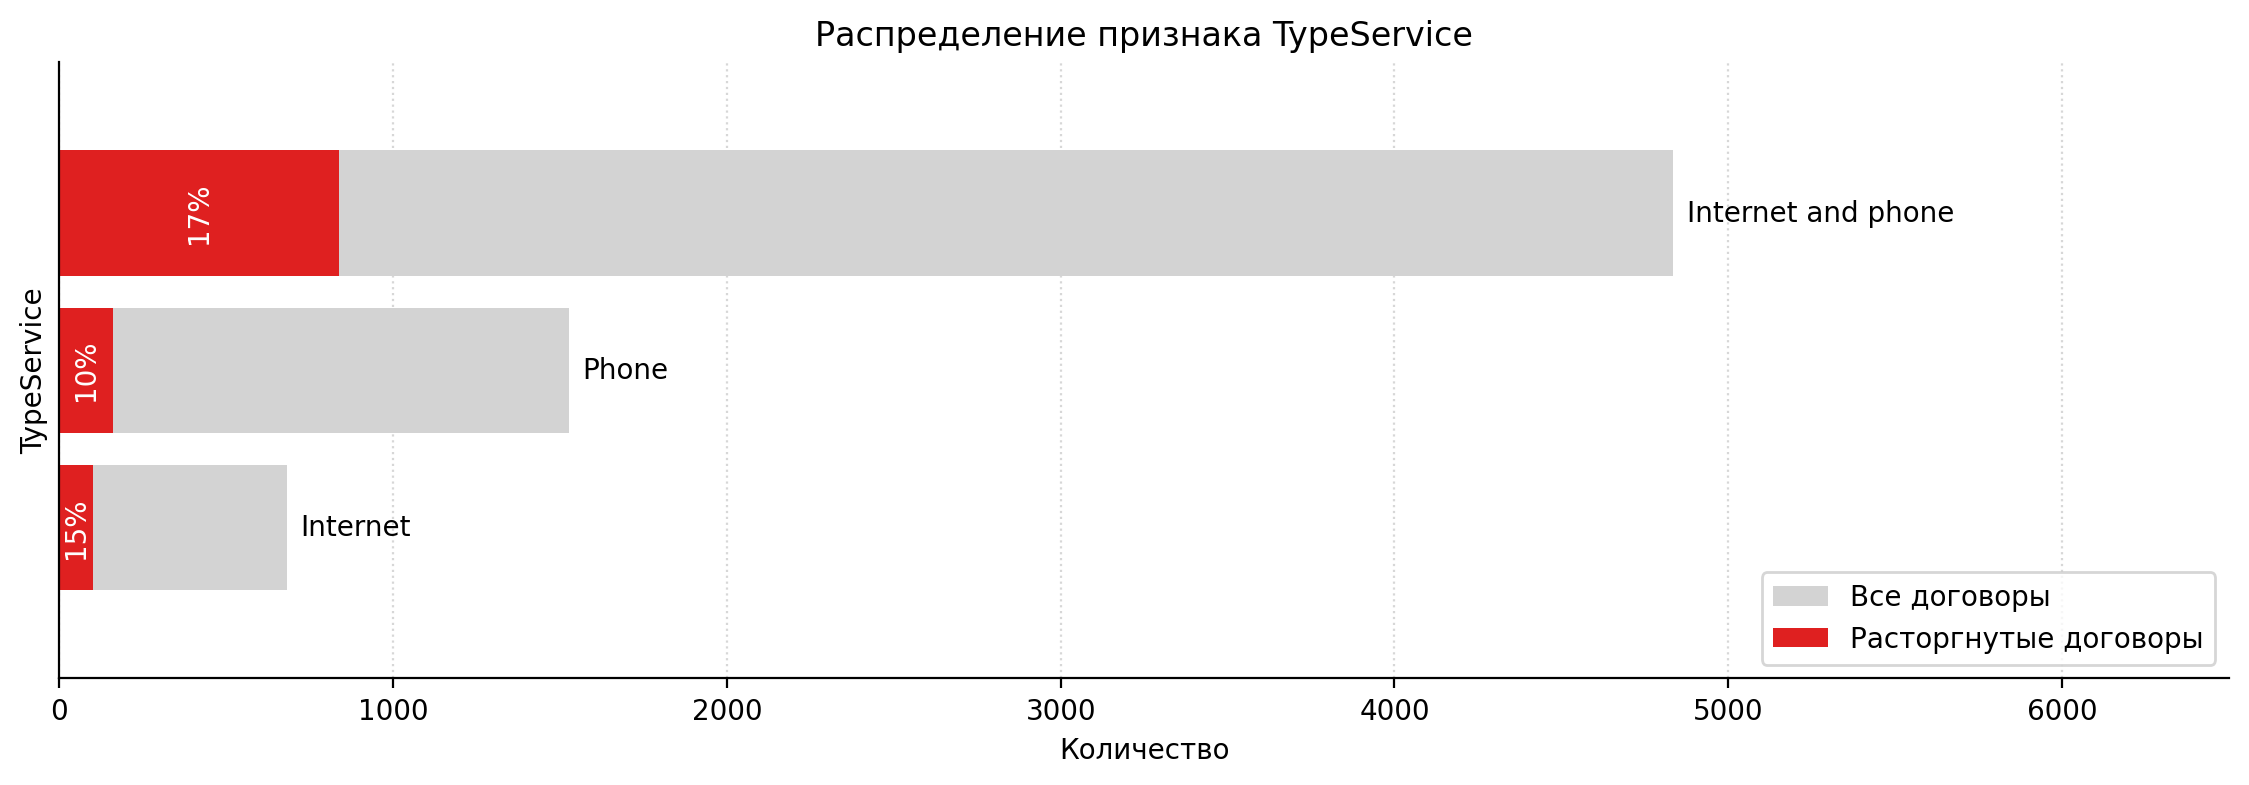

In [98]:
for column in cat_columns:
    fig, ax = plt.subplots(figsize=(14, 4))

    grouped = (
        union_df.groupby(column)['Reject']
        .agg(total_count='count', rejected_count=lambda x: x[x == 'Yes'].count())
        .sort_values(by='total_count', ascending=False)
    )
    grouped['rejected_pct'] = grouped['rejected_count'] / grouped['total_count'] * 100

    sns.barplot(
        x=grouped['total_count'], 
        y=grouped.index, 
        color='lightgray', 
        label='Все договоры', 
        ax=ax
    )
    sns.barplot(
        x=grouped['rejected_count'], 
        y=grouped.index, 
        color='red', 
        label='Расторгнутые договоры', 
        ax=ax
    )
    ax.bar_label(
        ax.containers[0], 
        labels=grouped.index, 
        label_type='edge', 
        padding=5
    )
    ax.bar_label(
        ax.containers[1],
        labels=[f'{x:.0f}%' for x in grouped['rejected_pct']],
        label_type='center',
        color='white',
        rotation=90
    )
    ax.set_title(f'Распределение признака {column}')
    ax.set_xlabel('Количество')
    ax.set_ylabel(column)
    ax.set_axisbelow(True)
    ax.set_xlim(right=6500)
    ax.legend(loc='lower right')
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', alpha=0.5, linestyle=':')
    ax.margins(0.05, 0.2)
    
    plt.show()

Можно отметить, что:
- все количественные признаки имеют от 2 до 4 значений, при кодировании можно использовать `OneHotEncoder`;
- практически во всех признаках наблюдается дисбаланс классов;
- низкой долей расторгнутых договоров выделяются:
    - клиенты с ежемесячной оплатой;
    - клиенты, которые для оплаты отправляют чек по почте;
    - клиенты, не состоящие в браке.
- высокой долей расторгнутых договоров выделяются: 
    - клиенты, подключенные к интернету оптоволоконным кабелем;
    - клиенты, которым оказываются дополнительные услуги;
    - клиенты, которым одновременно предоставляются услуги как интернета, так и телефонии.

### Целевой признак

Изучим распределение целевого признака `Reject` (разорван ли договор).

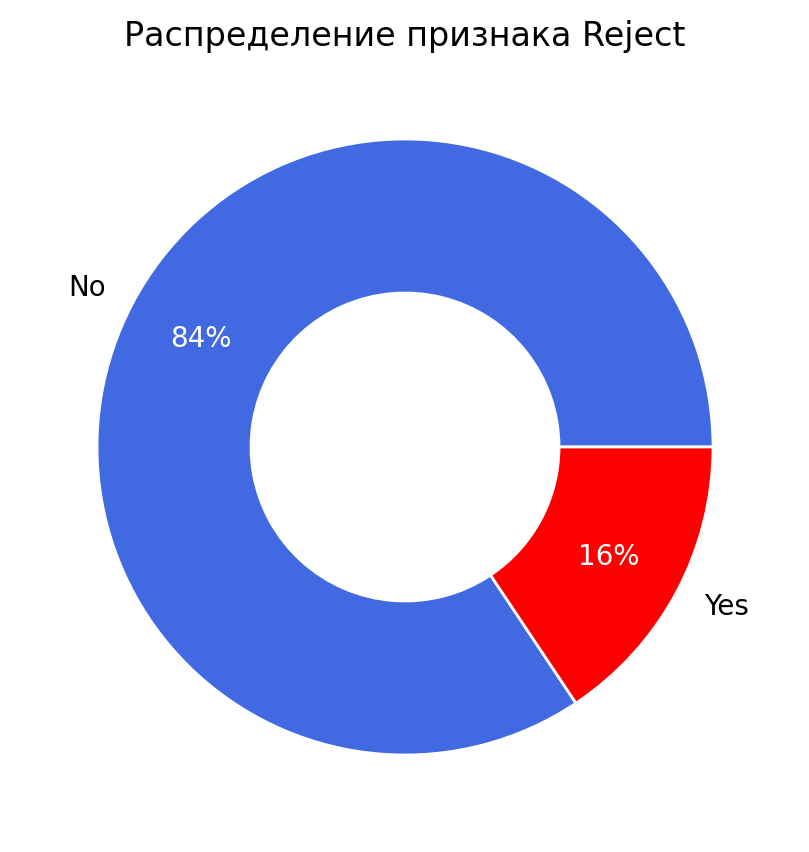

In [102]:
fig, ax = plt.subplots(figsize=(5, 5))

target_classes = union_df['Reject'].value_counts()
_, _, autotexts = ax.pie(
    target_classes,
    labels=target_classes.index,
    autopct='%.0f%%', 
    pctdistance=0.75, 
    colors=['royalblue', 'red'], 
    wedgeprops={'edgecolor': 'white', 'width': 0.5}
)
ax.set_title(f'Распределение признака Reject')
for autotext in autotexts:
    autotext.set_color('white')

plt.show()

Очевидный дисбаланс классов целевого признака — в датасете ~84% активных договоров и ~16% разорванных. Важно не забыть про **стратификацию данных** при разделении данных на тренировочную и тестовую выборки.

## Корреляционный анализ данных

Количественные признаки в датасете распределены не нормально, кроме того большинство признаков категориальные — поэтому для оценки взаимосвязей признаков рассчитаем коэффициенты корреляции Фи. Посмотрим тепловую карту матрицы корреляций, особенно на корреляцию признаков с таргетом `Reject`.

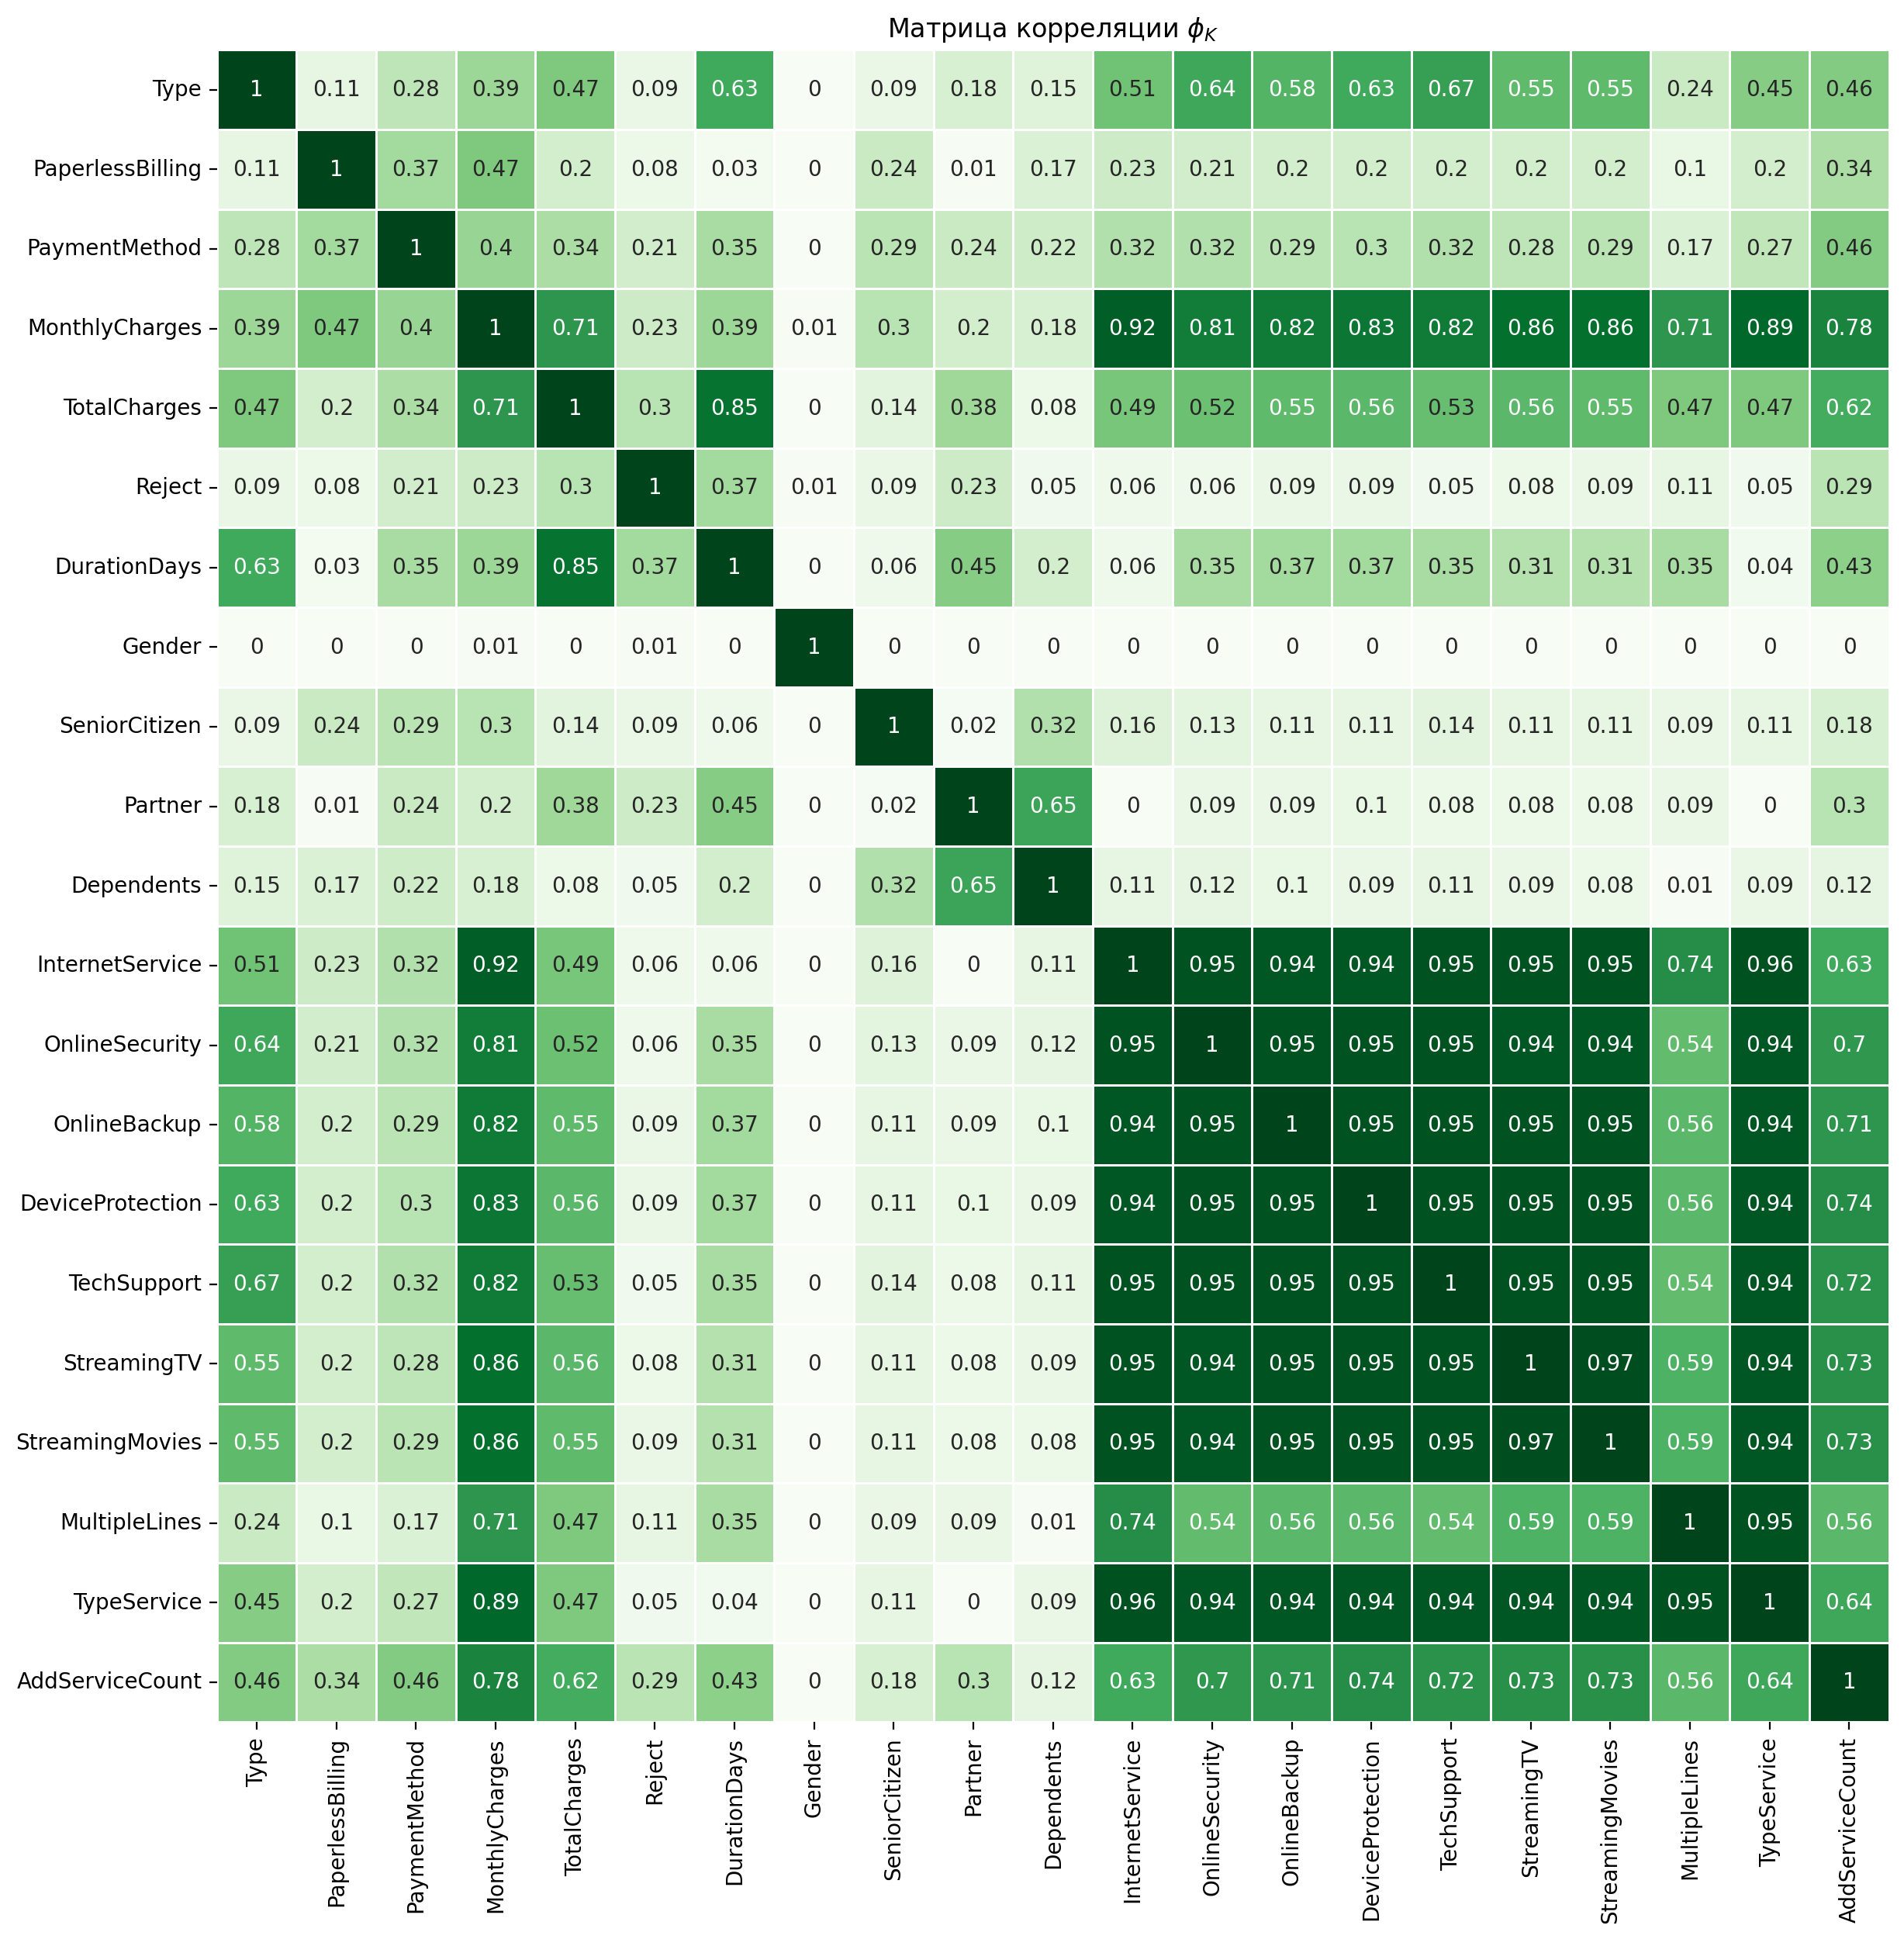

In [106]:
corr_coefs = union_df.phik_matrix(
    interval_cols=['MonthlyCharges', 'TotalCharges', 'DurationDays', 'AddServiceCount']
)

fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(np.round(corr_coefs, 2), annot=True, cbar=False, square=True, linewidths=0.5, cmap='Greens', ax=ax)
ax.set_title(r'Матрица корреляции $\phi_K$')
plt.show()

Можно отметить, что:
- пол клиента `Gender` практически никак не коррелирует ни с входными, ни с целевым признаком;
- признаки, отвечающие за дополнительные интернет-услуги, обладают весьма высокой корреляцией друг с другом — это объясняется тем, что если клиент не подключен к интернету, во всех этих признаках будет заглушка `No service`;
- целевой признак `Reject` обладает слабой корреляцией с типом платежа `PaymentMethod`, расходами за месяц `MonthlyCharges`, семейным статусом клиента `Partner`, подключением телефона к нескольким линиям одновременно `MultipleLines` и количеством подключенных дополнительных услуг `AddServiceCount`;
- целевой признак `Reject` обладает умеренной корреляцией с общими расходами абонента `TotalCharges` и длительностью договора `DurationDays`.

## Обучение моделей

### Подготовка выборок

Еще раз посмотрим на объединённый датафрейм `union_df`.

In [111]:
union_df.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Reject,DurationDays,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,TypeService,AddServiceCount
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,No,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No service,Internet,1
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,No,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,Internet and phone,2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,No,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,Internet and phone,2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,No,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No service,Internet,3
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,No,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,Internet and phone,0


Разделим данные на тренировочную и тестовую выборки в соотношении 3 к 1, не забыв про стратификацию по таргету.

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    union_df.drop('Reject', axis=1),
    union_df['Reject'],
    test_size=0.25, 
    stratify=union_df['Reject'],
    random_state=RANDOM_STATE
)
X_train.shape, X_test.shape

((5282, 20), (1761, 20))

Для кодирования целевого признака воспользуемся кодировщиком `LabelEncoder`. Принудительно закодируем единицей положительный класс (договор разорван).

In [115]:
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['No', 'Yes'])

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

pd.DataFrame({
    'Reject': label_encoder.classes_, 
    'EncodedReject': label_encoder.transform(label_encoder.classes_)
})

,Reject,EncodedReject
0,No,0
1,Yes,1


Изменим тип данных для категориальных признаков на тип `category` — это пригодится для модели градиентного бустинга `LGBMClassifier`.

In [117]:
for X in X_train, X_test:
    for column in X.select_dtypes(include='object').columns:
        X[column] = X[column].astype('category')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 0125-LZQXK to 5039-LZRQT
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              5282 non-null   category
 1   PaperlessBilling  5282 non-null   category
 2   PaymentMethod     5282 non-null   category
 3   MonthlyCharges    5282 non-null   float64 
 4   TotalCharges      5282 non-null   float64 
 5   DurationDays      5282 non-null   int64   
 6   Gender            5282 non-null   category
 7   SeniorCitizen     5282 non-null   category
 8   Partner           5282 non-null   category
 9   Dependents        5282 non-null   category
 10  InternetService   5282 non-null   category
 11  OnlineSecurity    5282 non-null   category
 12  OnlineBackup      5282 non-null   category
 13  DeviceProtection  5282 non-null   category
 14  TechSupport       5282 non-null   category
 15  StreamingTV       5282 non-null   category
 16  StreamingMovie

### Обучение

Определим веса классов таргета.

In [120]:
class_weights = {0: 1, 1: len(y_train) / y_train.sum()}
class_weights

{0: 1, 1: 6.394673123486683}

Для подготовки входных признаков создадим `ColumnTransformer` из нескольких преобразований:
- масштабирование количественных признаков;
- кодирование категориальных признаков.

Для моделей разного типа будем использовать только необходимые преобразования.

In [122]:
data_preprocessor = ColumnTransformer(
    transformers=[
        (
            'num_scaler', 
            MinMaxScaler(), 
            make_column_selector(dtype_include=np.number)
        ),
        (
            'ohe_encoder', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 
            make_column_selector(dtype_exclude=np.number)
        )
    ], 
    remainder='drop', 
    verbose_feature_names_out=False
).set_output(transform='pandas')

Подготовим пайплайн модели, включающий отбор и подготовку входных признаков, а также саму модель.

In [124]:
model_pipe = Pipeline(
    steps=[
        ('selector', ColumnSelector()),
        ('preprocessor', data_preprocessor),
        ('model', LogisticRegression())
    ]
)

В качестве моделей возьмём:
- логистическую регрессию `LogisticRegression`,
- метод опорных векторов `SVC`,
- модели градиентного бустинга `CatBoostClassifier` и `LGBMClassifier`.

Подберем гиперпараметры с помощью класса `GridSearchCV`. Для оценки качества модели применим метрику ROC-AUC, которая не зависит от выбранного порога классификации. Для стратифицированного разбиения данных на выборки при кросс-валидации будем пользоваться классом `StratifiedKFold`.

In [126]:
%%time

param_grid = [
    {
        'selector__columns': [
            [
                'Type', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 
                'SeniorCitizen', 'Partner', 'InternetService', 'OnlineBackup', 
                'TechSupport', 'StreamingMovies', 'MultipleLines', 'AddServiceCount'
            ]
        ],
        'preprocessor__num_scaler': [StandardScaler()],
        'preprocessor__ohe_encoder__drop': ['first', 'if_binary'],
        'model': [
            LogisticRegression(
                max_iter=2000, 
                random_state=RANDOM_STATE
            )
        ],
        'model__C': [0.1, 1, 2, 10],
        'model__class_weight': ['balanced'], 
        'model__fit_intercept': [True],
        'model__solver': ['lbfgs', 'liblinear']
    },
    {
        'selector__columns': [
            [
                'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
                'TotalCharges', 'DurationDays', 'Partner', 'InternetService',
                'MultipleLines', 'TypeService'
            ]
        ],
        'preprocessor__num_scaler': [StandardScaler()],
        'preprocessor__ohe_encoder__drop': ['first'],
        'model': [
            SVC(
                probability=True,
                random_state=RANDOM_STATE
            )
        ],
        'model__class_weight': ['balanced'],
        'model__kernel': ['rbf', 'poly'],
        'model__degree': [2, 3]
    },
    {
        'selector__columns': [X_train.columns],
        'preprocessor__num_scaler': ['passthrough'],
        'preprocessor__ohe_encoder': ['passthrough'],
        'model': [
            CatBoostClassifier(
                cat_features=list(X_train.select_dtypes(exclude=np.number).columns),
                loss_function='Logloss',
                verbose=False, 
                random_state=RANDOM_STATE
            )
        ],
        'model__class_weights': [class_weights],
        'model__iterations': [500],
        'model__max_depth': [3, 4, 5]
    },
    {
        'selector__columns': [X_train.columns],
        'preprocessor__num_scaler': ['passthrough'],
        'preprocessor__ohe_encoder': ['passthrough'],
        'model': [
            LGBMClassifier(
                objective='binary', 
                metric='logloss', 
                force_row_wise=True, 
                verbose=0, 
                random_state=RANDOM_STATE
            )
        ],
        'model__boosting_type': ['gbdt'],
        'model__class_weight': [class_weights],
        'model__max_bin': [500],
        'model__n_estimators': [100, 1000]
    }
]

splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

grid_search_cv = GridSearchCV(
    estimator=model_pipe, 
    param_grid=param_grid, 
    cv=splitter.split(X_train, y_train), 
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_cv.fit(X_train, y_train)

f'ROC-AUC лучшей модели при кросс-валидации: {grid_search_cv.best_score_:.4f}'

CPU times: total: 6.52 s
Wall time: 1min 20s


'ROC-AUC лучшей модели при кросс-валидации: 0.8719'

### Анализ результатов

Посмотрим на результаты лучших моделей каждого типа.

In [129]:
results_columns = {
    'model': 'Модель', 
    'rank_test_score': 'Ранг',
    'mean_test_score': 'ROC-AUC при кросс-валидации',
    'params': 'Параметры', 
    'mean_fit_time': 'Время обучения', 
    'mean_score_time': 'Время предсказания'
}

results = pd.DataFrame(grid_search_cv.cv_results_)
results['model'] = results['param_model'].apply(lambda x: x.__class__.__name__)
for column in ['mean_test_score', 'mean_fit_time', 'mean_score_time']:
    results[column] = np.round(results[column], 2)

results = (
    results
    .sort_values(by='rank_test_score')
    .pivot_table(index='model', aggfunc='first')
    .sort_values(by='rank_test_score')
    .reset_index()[results_columns.keys()]
    .rename(columns=results_columns)
)
results

,Модель,Ранг,ROC-AUC при кросс-валидации,Параметры,Время обучения,Время предсказания
0,LGBMClassifier,1,0.87,"{'model': LGBMClassifier(force_row_wise=True, metric='logloss', objective='binary', random_state=42, verbose=0), 'model__boosting_type': 'gbdt', 'model__class_weight': {0: 1, 1: 6.394673123486683}, 'model__max_bin': 500, 'model__n_estimators': 1000, 'preprocessor__num_scaler': 'passthrough', 'preprocessor__ohe_encoder': 'passthrough', 'selector__columns': ['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'DurationDays', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'TypeService', 'AddServiceCount']}",11.29,0.09
1,CatBoostClassifier,2,0.86,"{'model': <catboost.core.CatBoostClassifier object at 0x00000201E36C00E0>, 'model__class_weights': {0: 1, 1: 6.394673123486683}, 'model__iterations': 500, 'model__max_depth': 5, 'preprocessor__num_scaler': 'passthrough', 'preprocessor__ohe_encoder': 'passthrough', 'selector__columns': ['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'DurationDays', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'TypeService', 'AddServiceCount']}",31.46,0.02
2,SVC,6,0.82,"{'model': SVC(probability=True, random_state=42), 'model__class_weight': 'balanced', 'model__degree': 2, 'model__kernel': 'poly', 'preprocessor__num_scaler': StandardScaler(), 'preprocessor__ohe_encoder__drop': 'first', 'selector__columns': ['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'DurationDays', 'Partner', 'InternetService', 'MultipleLines', 'TypeService']}",5.32,0.28
3,LogisticRegression,10,0.77,"{'model': LogisticRegression(max_iter=2000, random_state=42), 'model__C': 10, 'model__class_weight': 'balanced', 'model__fit_intercept': True, 'model__solver': 'lbfgs', 'preprocessor__num_scaler': StandardScaler(), 'preprocessor__ohe_encoder__drop': 'first', 'selector__columns': ['Type', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'SeniorCitizen', 'Partner', 'InternetService', 'OnlineBackup', 'TechSupport', 'StreamingMovies', 'MultipleLines', 'AddServiceCount']}",0.08,0.03


Лучшие результаты показала модель градиентного бустинга `LGBMClassifier`. Посмотрим на метрики этой модели на тестовых данных.

In [131]:
predict_test = grid_search_cv.predict(X_test)
predict_proba_test = grid_search_cv.predict_proba(X_test)[:, 1]

metrics = {
    'accuracy': accuracy_score(y_test, predict_test), 
    'precision': precision_score(y_test, predict_test), 
    'recall': recall_score(y_test, predict_test), 
    'ROC-AUC': roc_auc_score(y_test, predict_proba_test)
}

display('Результаты лучшей модели на тестовой выборке:')
for key, value in metrics.items():
    display(f'{key}: {value:.2f}')

'Результаты лучшей модели на тестовой выборке:'

'accuracy: 0.90'

'precision: 0.74'

'recall: 0.60'

'ROC-AUC: 0.90'

**ROC-AUC выбранной модели на тестовой выборке ~0.9**, то есть модель удовлетворяет требования заказчика. Метрика accuracy говорит о том, что модель верно определяет, будет ли разорван договор, примерно в 90% случаев. Стоит отметить, что модель обладает не самой высокой полнотой. Повлиять на ситуацию с ошибками первого и второго рода можно было изменением порога классификации, однако заказчик не определил требования к тому, что для него важнее: не пропустить клиентов, которые разорвут договор, или же не присвоить «остающимся» клиентом класс «уходящих».

Теперь построим матрицу ошибок.

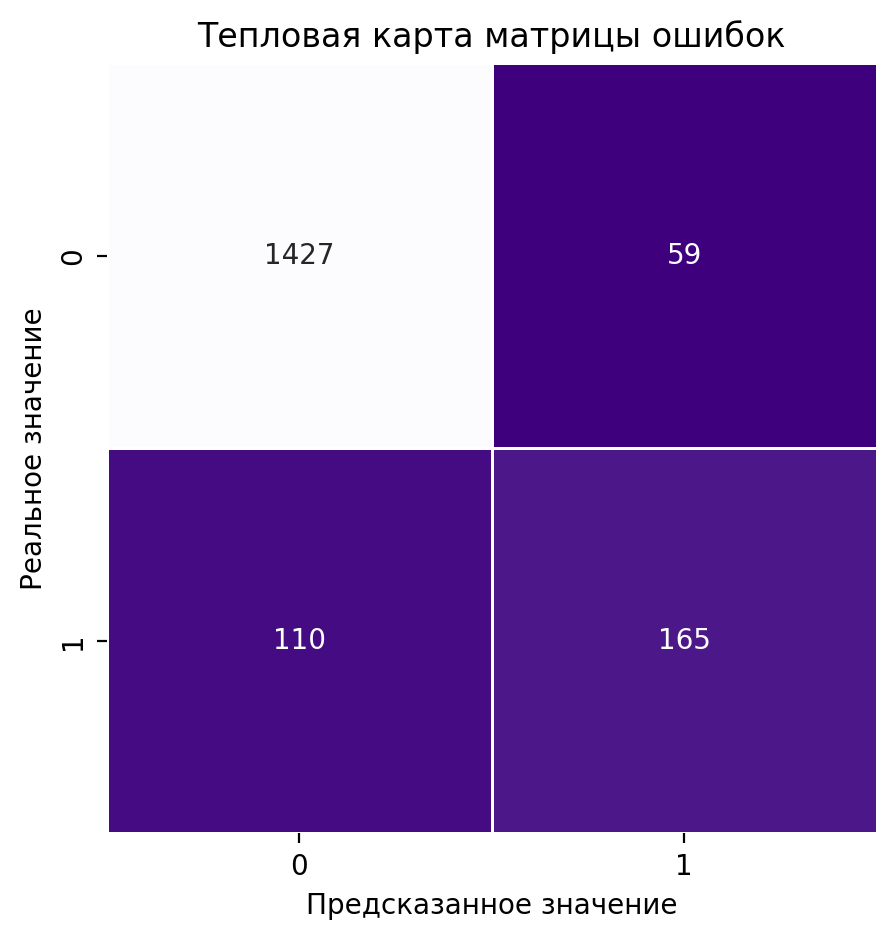

In [134]:
fig, ax = plt.subplots(figsize=(5, 5))

cm = confusion_matrix(y_test, predict_test)
sns.heatmap(cm, annot=True, square=True, cbar=False, fmt='d', linewidths=0.5, cmap='Purples_r', ax=ax)
ax.set_title('Тепловая карта матрицы ошибок')
ax.set_xlabel('Предсказанное значение')
ax.set_ylabel('Реальное значение')

plt.show()

Построим ROC-кривую, то есть зависимость TPR от FPR при разных порогах классификации.

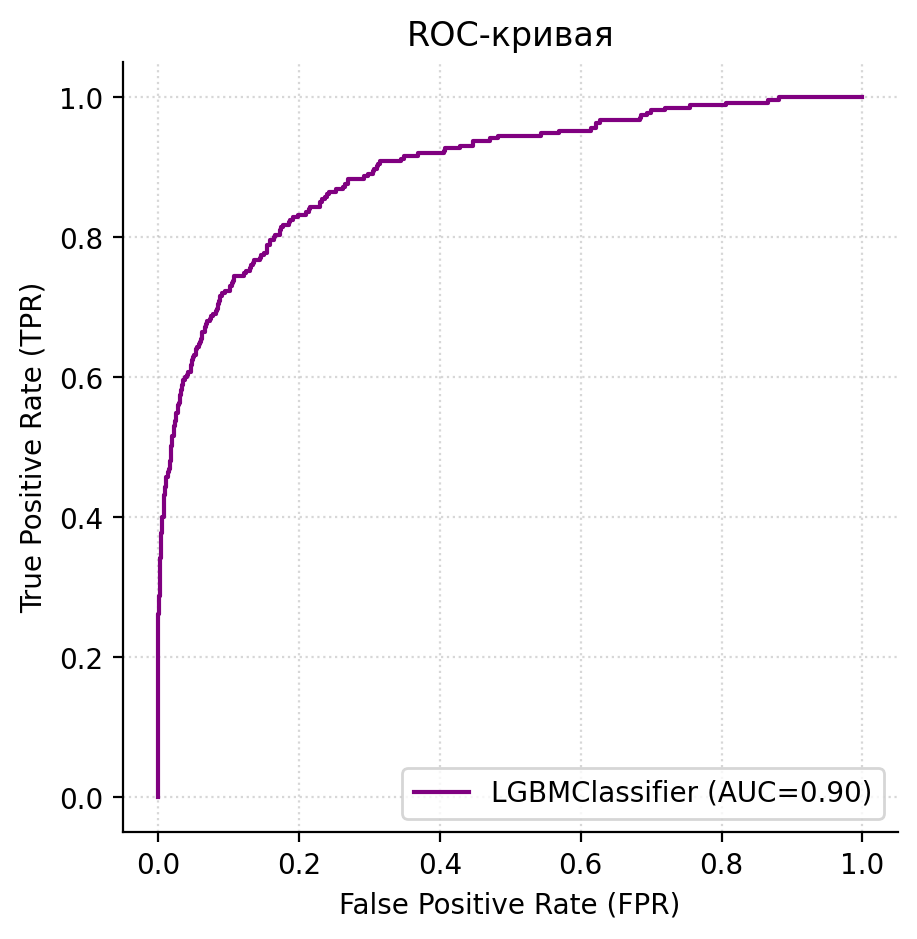

In [136]:
fpr, tpr, _ = roc_curve(y_test, predict_proba_test)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(fpr, tpr, color='purple', label=f'LGBMClassifier (AUC={metrics["ROC-AUC"]:.2f})')
ax.set_title('ROC-кривая')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.legend(loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.5, linestyle=':')

plt.show()

Оценим важность признаков выбранной модели.

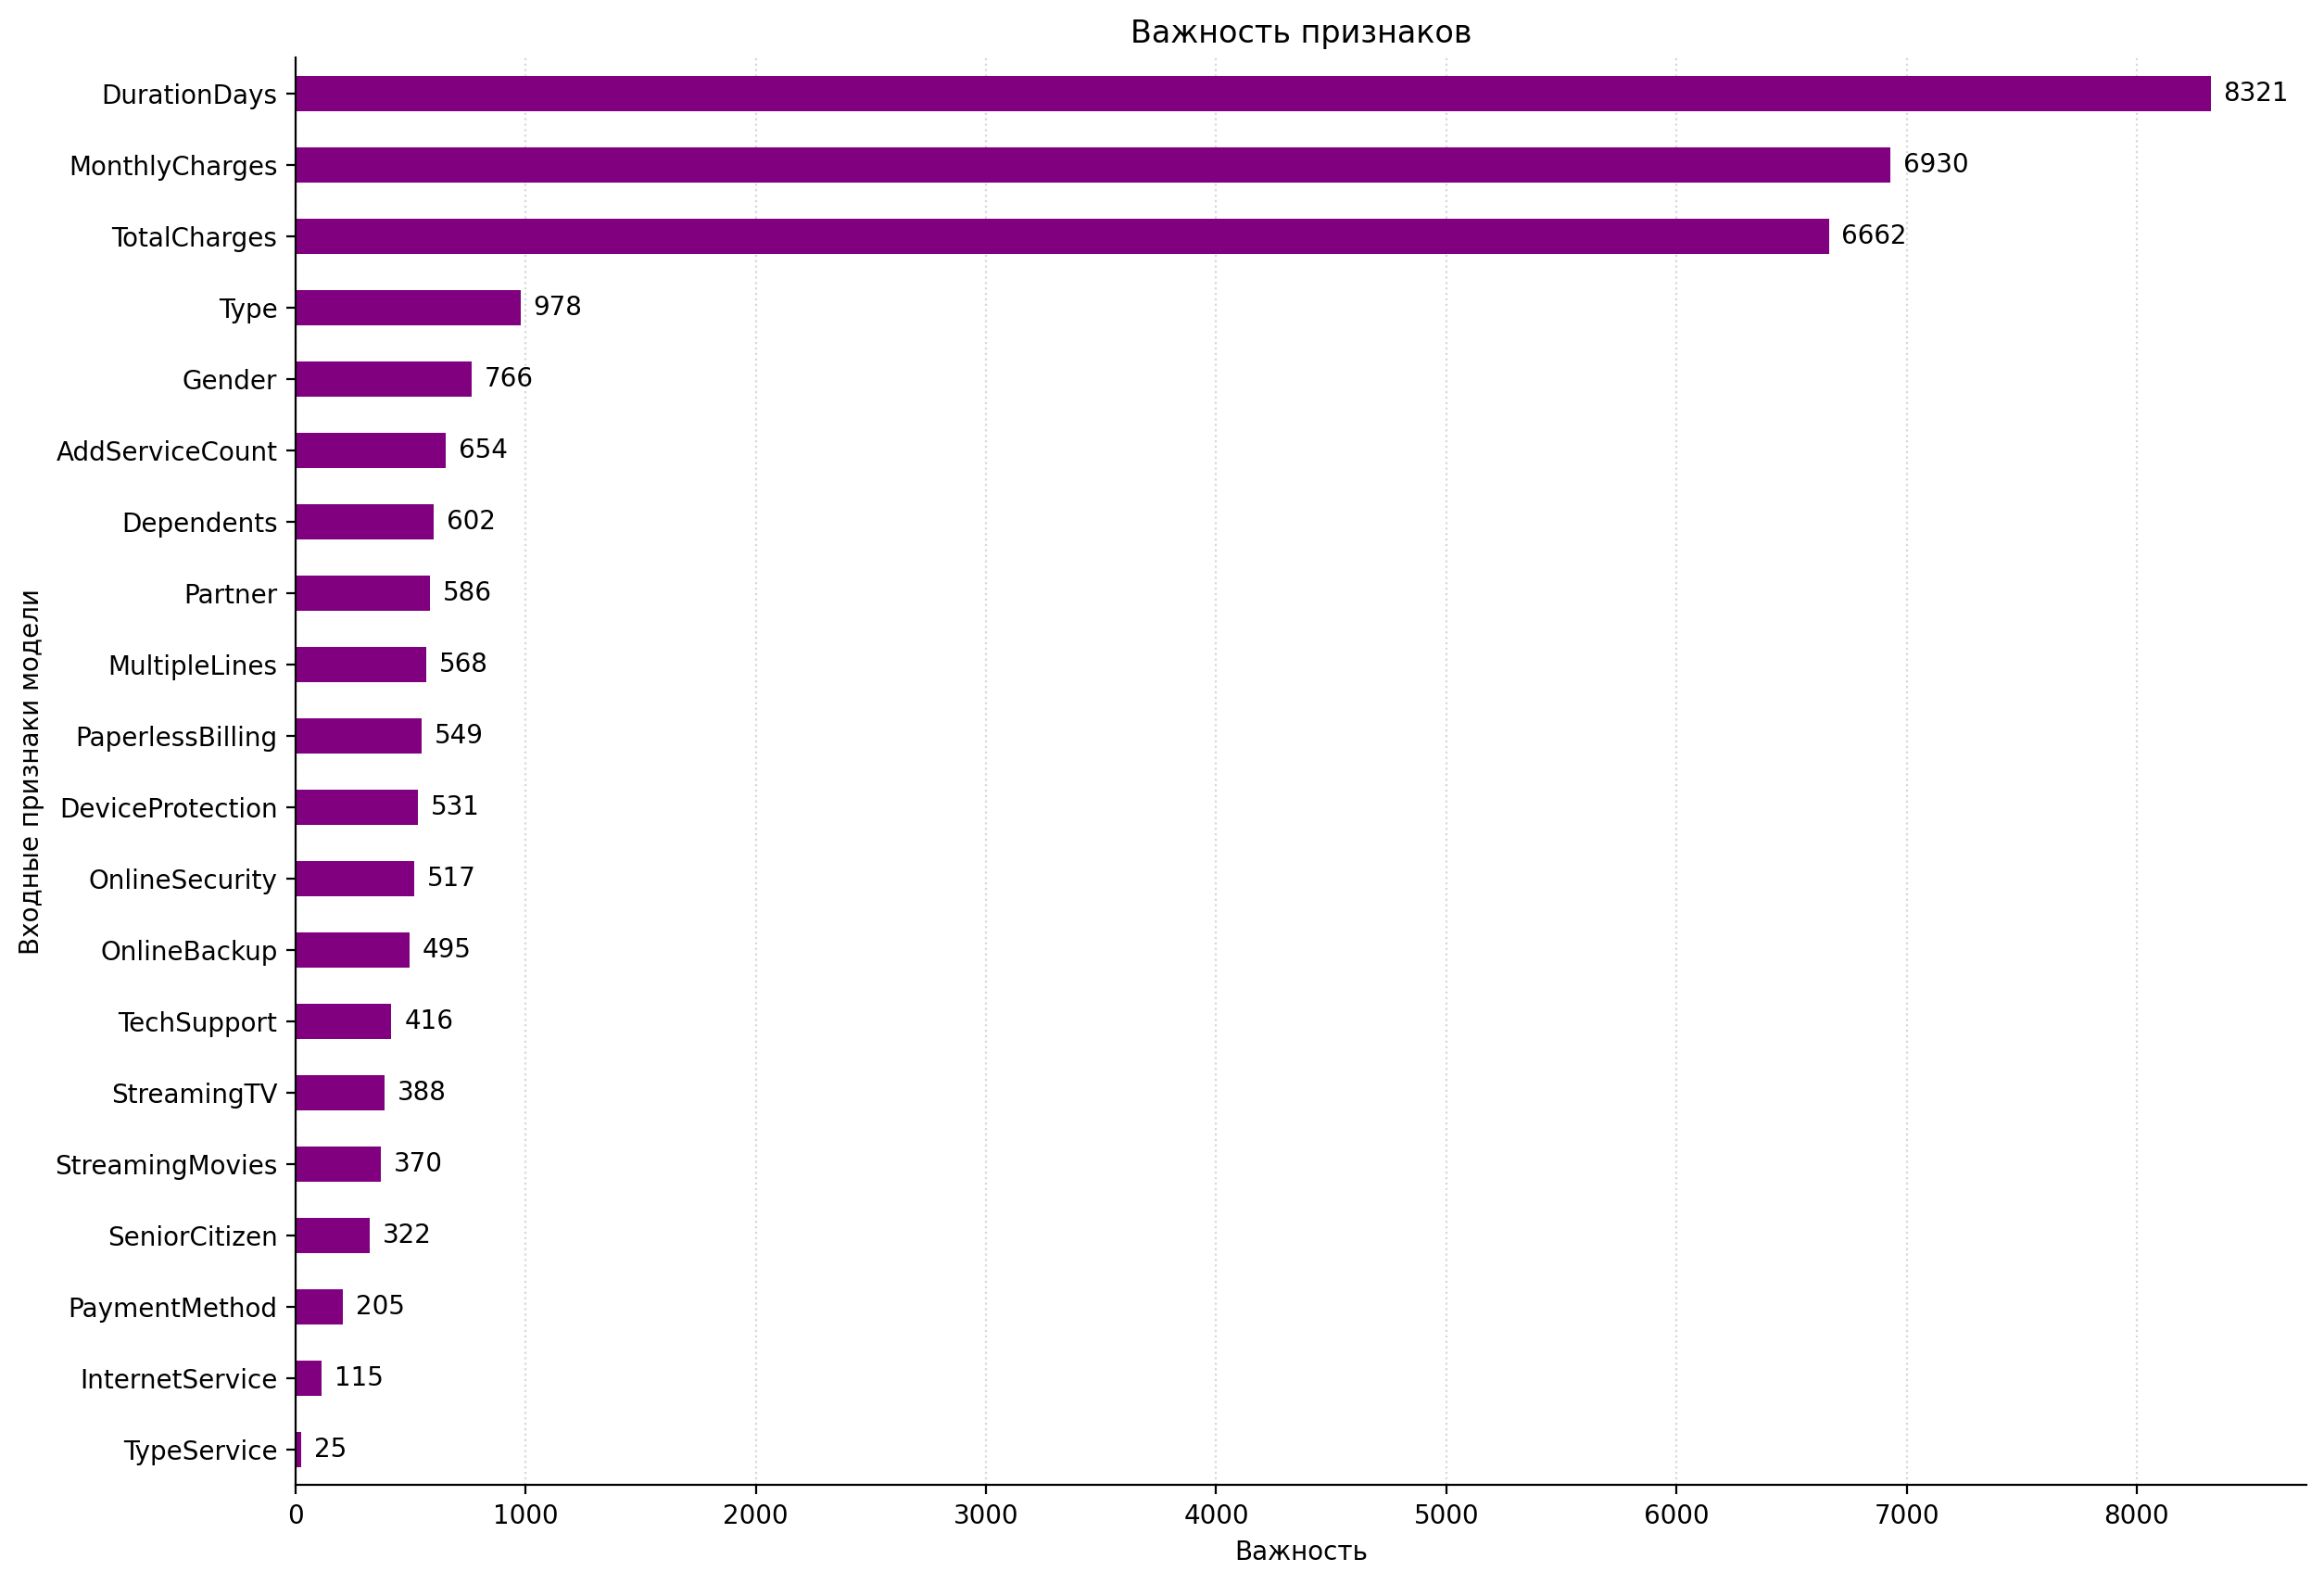

In [138]:
feature_importances = pd.Series(
    data=grid_search_cv.best_estimator_.named_steps['model'].feature_importances_,
    index=grid_search_cv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(14, 10))

feature_importances.plot(kind='barh', color='purple', ax=ax)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=5)
ax.set_title('Важность признаков')
ax.set_xlabel('Важность')
ax.set_ylabel('Входные признаки модели')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5, linestyle=':')

plt.show()

В число наиболее важных признаков для выбранной модели входят:
- длительность договора;
- расходы клиента за месяц;
- расходы клиента за весь период.

## Выводы

В ходе исследования обработаны и проанализированы данные оператора связи «ТелеДом» о некоторых клиентах, информацию об их тарифах и услугах (с октября 2013 года по февраль 2020 года). Построены модели, предсказывающие отток клиентов. Построенные модели проанализированы, и выбрана модель, наиболее подходящая под критерии заказчика.

В процессе **загрузки и предобработка данных**:
- Загружено 4 датасета с данными о клиентах, информацией об их тарифах и услугах. Все датасеты имеют признак с идентификатором абонента `customerID`.
- Заполнены пропущенные значения.
- Создан новый признак с длительностью договора.
- Выделен целевой признак (разорван ли договор).

В процессе **объединения данных**:
- Объединены 4 датафрейма с данными о 7043 клиентах, информацией об их тарифах и услугах.
- Пропущенные значения не являются ошибкой и не обусловлены нехваткой данных. Пропуски заменены на заглушки.
- Создан новый признак с основным типом услуг, предоставляемых клиенту.

По результатам **исследовательского анализа данных** можно отметить, что:
- аномальных значений и сильных выбросов в количественных признаках не обнаружено;
- количественные признаки распределены не нормально;
- распределения признака с длительностью договора в разбивке по таргету сильно отличаются друг от друга;
- все количественные признаки имеют от 2 до 4 значений;
- практически во всех признаках наблюдается дисбаланс классов;
- низкой долей расторгнутых договоров выделяются:
    - клиенты с ежемесячной оплатой;
    - клиенты, которые для оплаты отправляют чек по почте;
    - клиенты, не состоящие в браке.
- высокой долей расторгнутых договоров выделяются: 
    - клиенты, подключенные к интернету оптоволоконным кабелем;
    - клиенты, которым оказываются дополнительные услуги;
    - клиенты, которым одновременно предоставляются услуги как интернета, так и телефонии.
- наблюдается дисбаланс классов целевого признака — в датасете ~84% активных договоров и ~16% разорванных.

По результатам **корреляционного анализа данных** можно отметить, что:
- пол клиента практически никак не коррелирует ни с входными, ни с целевым признаком;
- признаки, отвечающие за дополнительные интернет-услуги, обладают весьма высокой корреляцией друг с другом — это объясняется тем, что если клиент не подключен к интернету, во всех этих признаках будет одинаковое значение;
- целевой признак обладает слабой корреляцией с типом платежа, расходами за месяц, семейным статусом клиента, подключением телефона к нескольким линиям одновременно и количеством подключенных дополнительных услуг;
- целевой признак обладает умеренной корреляцией с общими расходами абонента и длительностью договора.

В результате **обучения и анализа моделей**, предсказывающих отток клиентов:
- Заказчику рекомендуется использовать модель градиентного бустинга **`LGBMClassifier`**, которая удовлетворяет критерию оценки качества (значение метрики **ROC-AUC=0.9**), а также обладает приемлемыми временами обучения и предсказания.
- Метрика accuracy выбранной модели говорит о том, что модель верно определяет, будет ли разорван договор, примерно в 90% случаев.
- В число наиболее важных признаков для выбранной модели входят: длительность договора, расходы клиента за месяц, расходы клиента за весь период.

В качестве **рекомендации**: заказчику стоит определить требования к тому, что для него важнее — не пропустить клиентов, которые разорвут договор, или же не присвоить «остающимся» клиентом класс «уходящих». Это позволит настроить порог классификации для повышения качества предсказаний модели.